# Optically-dark short GRBs

## Imports/loading/setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, importlib
from astropy.io import votable, ascii
from scipy import interpolate
from custom_utils import AsymmetricUncertainty, custom_iter

alpha = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
numeric = ".0123456789"
calc_code = importlib.import_module("Calculation Code.main")
graph_code = importlib.import_module("Graphing Code.Graphing_Beta_OX")

In [4]:
swift = pd.read_html("https://swift.gsfc.nasa.gov/archive/grb_table/fullview/")[0] # get latest Swift catalog
swift.columns = [col[0] for col in swift.columns] # reduce/flatten MultiIndex
sGRBs = swift[swift["BAT T90[sec]"].apply(pd.to_numeric, errors="coerce") <= 2].copy() # filter catalog for GRBs with a valid T90 that is <2s

## Data parsing and cleanup

In [5]:
# format columns
sGRBs.drop(['Time[UT]', 'BAT RA(J2000)', 'BAT Dec(J2000)', 'BAT 90%Error Radius[arcmin]',
            'BAT Fluence(15-150 keV)[10-7 erg/cm2]', 'BAT Fluence90% Error(15-150 keV)[10-7 erg/cm2]',
            'BAT 1-sec PeakPhoton Flux(15-150 keV)[ph/cm2/sec]', 'BAT 1-sec PeakPhoton Flux90% Error(15-150 keV)[ph/cm2/sec]',
            'BAT Photon Index(15-150 keV)(PL = simple power-law,CPL = cutoff power-law)', 'BAT Photon Index90% Error(15-150 keV)',
            'XRT RA(J2000)', 'XRT Dec(J2000)', 'XRT 90%Error Radius[arcsec]', 'XRT Column Density(NH)[1021 cm-2]',
            'XRT Early Flux(0.3-10 keV)[10-11 erg/cm2/s]', 'XRT 11 Hour Flux(0.3-10 keV)[10-11 erg/cm2/s]',
            'XRT 24 Hour Flux(0.3-10 keV)[10-11 erg/cm2/s]', 'UVOT RA(J2000)', 'UVOT Dec(J2000)', 'UVOT 90%Error Radius[arcsec]',
            'Host Galaxy', 'Comments', 'References', 'Burst Advocate'],axis=1,inplace=True) # already in master catalog
sGRBs.rename(columns={'XRT Time to FirstObservation[sec]':'XRT dt [sec]',
                      'UVOT Time toFirst Observation[sec]':'UVOT dt [sec]',
                      'UVOT Other FilterMagnitudes':'Other UVOT Filters'},inplace=True)

mags = pd.Series([],dtype=float) # numerical magnitudes
lims = pd.Series([],dtype=object) # what kind of limit?
for idx,mag in sGRBs["UVOT Magnitude"].iteritems():
    #print(idx)
    try:
        mags[idx] = float(mag)
        lims[idx] = "equal"
    except ValueError:
        if ">" in mag:
            lims[idx] = "brightest"
            mags[idx] = float("".join([char for char in mag.split()[0] if char in "0123456789."]))
        elif "=" in mag:
            lims[idx] = "equal"
            mags[idx] = float("".join([char for char in mag.split()[0] if char in "0123456789."]))
        else:
            print(mag)
            lims[idx] = "equal"
            mags[idx] = np.nan

sGRBs["UVOT Vmag"] = mags
sGRBs["UVOT Vmag lim"] = lims

See GCN 10184


In [6]:
def split_filters(string):
    UVOT_filters = ["B","U","UVW1","UVM2","UVW2","White"]
    name_idxs = custom_iter([string.index(i) for i in UVOT_filters if i in string])
    split_list = [string[name_idxs.current:next(name_idxs)] for i in range(len(UVOT_filters))]
    split_list = [item for item in split_list if len(item)>0]
    return np.unique(split_list).tolist()

In [7]:
optical_obs = []
for idx,entry in sGRBs["Other UVOT Filters"].iteritems():
    if pd.isna(entry):
        entries = []
    else:
        entries = split_filters(entry)
    try:
        filterdict = dict([entry.split(">") if ">" in entry else entry.split("=") if "=" in entry else None for entry in entries])
        filterdict["idx"] = idx
        optical_obs.append(filterdict)
    except:
        print("error",idx,end="; ")

for obs in optical_obs:
    sGRBs["Other UVOT Filters"][obs["idx"]] = obs.copy()

error 213; error 341; error 520; error 561; error 609; error 638; error 720; error 853; error 1048; error 1063; error 1129; error 1282; 

<ipython-input-7-9935b0563a4e>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sGRBs["Other UVOT Filters"][obs["idx"]] = obs.copy()


In [8]:
sGRBs["Redshift"] = ["".join([char for char in entry if char in numeric]) if type(entry) is str else entry for entry in sGRBs["Redshift"]]

In [9]:
sGRBs.to_csv("./Required Files/Files for Loading/Swift_sGRB_catalog.csv",index=False)
sGRBs.head()

,GRB,TriggerNumber,BAT T90[sec],XRT dt [sec],XRT InitialTemporalIndex,XRTSpectral Index(Gamma),UVOT dt [sec],UVOT Magnitude,Other UVOT Filters,Other Observatory Detections,Redshift,UVOT Vmag,UVOT Vmag lim
19,201006A,998907,0.49,83.94,-0.986,2.11701,88,V>18.9,"{'B': '19.8', 'U': '20.3', 'UVW1': '18.7', 'UV...","INTEGRAL, Fermi (GBM)",NaN,18.9,brightest
27,200907B,995004,0.83,80.13,-2.087,1.96454,84,V>17.7,"{'B': '19.4', 'U': '20.4', 'UVM2': '18.3', 'UV...",AstroSat CZTI,NaN,17.7,brightest
53,200522A,973628,0.62,83.42,-0.6754,1.38048,448,V>17.2,"{'White': '19.5', 'idx': 53}","VLA @ 6 GHZ (possibly from host), LCO (1m), Ge...",0.4,17.2,brightest
62,200411A,965784,0.22,50.74,-0.9587,1.76864,58,V>18.5,"{'B': '20.3', 'U': '21.0', 'UVM2': '18.1', 'UV...",Fermi (GBM),NaN,18.5,brightest
100,191031D,932608,0.29,88.83,-1.982,1.88342,93,V>19.9,"{'B': '20.4', 'U': '20.3', 'UVM2': '19.6', 'UV...","Fermi (GBM), AGILE (MCAL), Konus-Wind, AstroSa...",NaN,19.9,brightest


## Legacy and new data imports

In [10]:
BetaXData = pd.read_csv("./Required Files/Legacy Data/BetaXData.csv", header=None)
BetaXData.columns = ["GRB","BetaX","Beta_X_pos","Beta_X_neg"]
BetaXData["GRB"] = [entry.split("-")[-1] for entry in BetaXData["GRB"]]

OpticalData = pd.read_csv("./Required Files/Legacy Data/OpticalData.csv", header=None)
OpticalData.columns = ["GRB","Time","Observatory","Instrument","Filter","Exposure","F_o","e_F_o"]
OpticalData["GRB"] = [entry.split("-")[-1] for entry in OpticalData["GRB"]]
# OpticalData["dt"] = OpticalData["dt"]*60*60

XRayData = pd.read_csv("./Required Files/Legacy Data/XRayData.csv", header=None)
XRayData.columns = ["GRB","Time","Exposure","F_x","e_F_x"]

filters = pd.read_csv("Required Files/Legacy Data/FilterInfo.csv", header=None)
filters.columns = ["Observatory","Instrument","Filter","Wavelength","Frequency"]

new_sGRBs = sGRBs[[int(grb[:6]) > 150301 for grb in sGRBs["GRB"]]].copy() # Fong et al. 2015 has data through March 2015, i.e. 150301A

In [11]:
new_sGRBs

,GRB,TriggerNumber,BAT T90[sec],XRT dt [sec],XRT InitialTemporalIndex,XRTSpectral Index(Gamma),UVOT dt [sec],UVOT Magnitude,Other UVOT Filters,Other Observatory Detections,Redshift,UVOT Vmag,UVOT Vmag lim
19,201006A,998907,0.49,83.94,-0.986,2.11701,88,V>18.9,"{'B': '19.8', 'U': '20.3', 'UVW1': '18.7', 'UV...","INTEGRAL, Fermi (GBM)",NaN,18.90,brightest
27,200907B,995004,0.83,80.13,-2.087,1.96454,84,V>17.7,"{'B': '19.4', 'U': '20.4', 'UVM2': '18.3', 'UV...",AstroSat CZTI,NaN,17.70,brightest
53,200522A,973628,0.62,83.42,-0.6754,1.38048,448,V>17.2,"{'White': '19.5', 'idx': 53}","VLA @ 6 GHZ (possibly from host), LCO (1m), Ge...",0.4,17.20,brightest
62,200411A,965784,0.22,50.74,-0.9587,1.76864,58,V>18.5,"{'B': '20.3', 'U': '21.0', 'UVM2': '18.1', 'UV...",Fermi (GBM),NaN,18.50,brightest
100,191031D,932608,0.29,88.83,-1.982,1.88342,93,V>19.9,"{'B': '20.4', 'U': '20.3', 'UVM2': '19.6', 'UV...","Fermi (GBM), AGILE (MCAL), Konus-Wind, AstroSa...",NaN,19.90,brightest
130,190627A,911609,1.60,109.76,-0.3297,1.95997,115,NaN,"{'White': '18.15', 'idx': 130}","NUTTelA-TAO, Montarrenti Observatory (0.53m), ...",1.942,NaN,equal
134,190610A,907754,0.62,292300,NaN,NaN,292282,V>20.3,{'idx': 134},"Insight-HXMT/HE, CALET, Konus-Wind",NaN,20.30,brightest
142,190427A,900730,0.3,3735.8,NaN,NaN,3737,NaN,"{'U': '19.9', 'idx': 142}","Fermi (GBM), CALET (CGBM)",NaN,NaN,equal
148,190326A,895006,0.08,NaN,NaN,NaN,NaN,NaN,"{'UVW1': '20.47', 'idx': 148}",Insight-HXMT/HE,NaN,NaN,equal
177,181123B,873186,0.26,80.25,-1.404,1.98751,84,V>19.8,"{'B': '20.1', 'U': '20.1', 'UVM2': '20.5', 'UV...",Insight-HXMT/HE,NaN,19.80,brightest


## Retrieve Swift XRT light curve and spectrum

In [12]:
def XRT_lightcurve(burst_id):
    trigger = swift.loc[swift["GRB"] == burst_id, "TriggerNumber"]
    lightcurveURL = f"https://www.swift.ac.uk/xrt_curves/{int(trigger):0>8}/flux.qdp"
    
    fluxdata = pd.read_table(lightcurveURL, header=11).apply(pd.to_numeric, errors="coerce").dropna().reset_index(drop=True)
    fluxdata.columns = ["Time","Tpos","Tneg","Flux","Fluxpos","Fluxneg"]
    fluxdata["GRB"] = [burst_id]*len(fluxdata)
    
    return fluxdata


def get_BetaX(burst_id):
    trigger = swift.loc[swift["GRB"] == burst_id, "TriggerNumber"]
    spectrumURL = f"https://www.swift.ac.uk/xrt_spectra/{int(trigger):0>8}/"
    
    spectra_tables = pd.read_html(spectrumURL)
    PC_table = spectra_tables[len(spectra_tables)-2]
    photon_index = PC_table.loc[PC_table[0]=="Photon index",1].values
    (Gamma, Gammapos, Gammaneg) = (float(num) for num in "".join([char for char in str(photon_index[0]) if char not in "[]()+-,"]).split())
    
    return Gamma, Gammapos, Gammaneg

In [36]:
burst = "200522A"
fluxdata = XRT_lightcurve(burst)
Gamma, Gammapos, Gammaneg = get_BetaX(burst)

Text(0, 0.5, 'Flux density')

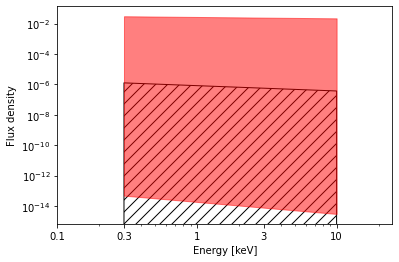

In [37]:
E_range = np.linspace(0.3,10,100)
spectrum = (E_range / 4.135667696e-18)**-(Gamma-1)
spec1 = (E_range / 4.135667696e-18)**-(Gamma+Gammapos-1)
spec2 = (E_range / 4.135667696e-18)**-(Gamma-Gammaneg-1)

plt.fill_between(E_range,[0]*len(E_range),spectrum,fc="none",ec="k",hatch="//")
plt.fill_between(E_range,spec1,spec2,alpha=0.5,color="r")
plt.xlim(1e-1,25)
#plt.ylim(1e-16,1e-4)
plt.yscale("log")
plt.xscale("log")
plt.gca().set_xticks([0.1,0.3,1,3,10])
plt.gca().set_xticklabels([0.1,0.3,1,3,10])
#plt.gca().set_yticks([])
#plt.gca().set_yticklabels([])
plt.xlabel("Energy [keV]")
plt.ylabel("Flux density")

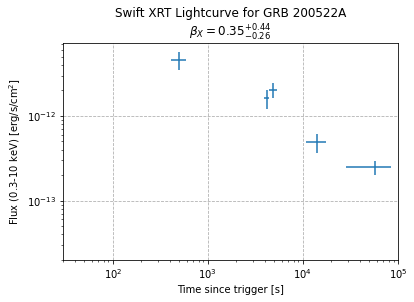

In [38]:
plt.errorbar(fluxdata.Time,fluxdata.Flux,xerr=np.array(fluxdata.Tneg,fluxdata.Tpos).T,yerr=np.array(fluxdata.Fluxneg,fluxdata.Fluxpos).T,linestyle="",capthick=0)
plt.xscale("log")
plt.yscale("log")
plt.title("Swift XRT Lightcurve for GRB %s\n$\\beta_X = %.2f_{-%.2f}^{+%.2f}$" % (burst,Gamma-1.,Gammaneg,Gammapos))
plt.xlabel("Time since trigger [s]")
plt.ylabel("Flux (0.3-10 keV) [erg/s/cm$^2$]")
plt.grid(linestyle="--")
plt.xlim(3e1,1e5)
plt.show()

In [16]:
xrt_data = pd.DataFrame(columns=['Time', 'Tpos', 'Tneg', 'Flux', 'Fluxpos', 'Fluxneg', 'GRB'])
for i in new_sGRBs.index:
    GRB_ID = new_sGRBs.loc[i,"GRB"]
    
    try:
        Gamma, Gammapos, Gammanegb = get_BetaX(GRB_ID)
        fluxdata = XRT_lightcurve(GRB_ID)
        xrt_data = xrt_data.append(fluxdata,ignore_index=True)
        
        new_sGRBs.loc[i,"Beta_X"] = Gamma - 1
        new_sGRBs.loc[i,"Beta_X_neg"] = Gammaneg
        new_sGRBs.loc[i,"Beta_X_pos"] = Gammapos
        #print(f"Found {GRB_ID} at index {i}: {Gamma, Gammapos, Gammaneg}")
        
    except:
        print("Failed to retrieve",GRB_ID)

Failed to retrieve 190610A
Failed to retrieve 190427A
Failed to retrieve 190326A
Failed to retrieve 180718A
Failed to retrieve 180715A
Failed to retrieve 170325A
Failed to retrieve 170112A
Failed to retrieve 160726A
Failed to retrieve 160714A
Failed to retrieve 151228A
Failed to retrieve 151205B
Failed to retrieve 150710A


## Converting x-ray flux values to spectral flux densities

$$ F_\text{x} = \int_{0.3\text{ keV}}^{10\text{ keV}} F(E)\ dE = \int_{7.254\cdot10^{16}\text{ Hz}}^{2.418\cdot10^{18}\text{ Hz}} F_\nu\ d\nu = A \int_{7.254\cdot10^{16}\text{ Hz}}^{2.418\cdot10^{18}\text{ Hz}} \nu^{-\beta}\ d\nu $$
$$ F_\text{x} = \left.\begin{cases} A\frac{\nu^{1-\beta}}{1-\beta}, & \beta \neq 1 \\ A\ln(\nu), & \beta = 1 \end{cases}\right\}_{7.254\cdot10^{16}\text{ Hz}}^{2.418\cdot10^{18}\text{ Hz}} $$

In [17]:
for i in xrt_data.index:
    grb_id = xrt_data.loc[i,"GRB"]
    beta = AsymmetricUncertainty(float(new_sGRBs.loc[new_sGRBs["GRB"]==grb_id,"Beta_X"]),
                                 float(new_sGRBs.loc[new_sGRBs["GRB"]==grb_id,"Beta_X_pos"]/1.645), # convert 90% conf to 1-sigma
                                 float(new_sGRBs.loc[new_sGRBs["GRB"]==grb_id,"Beta_X_neg"]/1.645)) # convert 90% conf to 1-sigma
    Fx = AsymmetricUncertainty(xrt_data.loc[i,"Flux"], xrt_data.loc[i,"Fluxpos"], np.abs(xrt_data.loc[i,"Fluxneg"]))
    if beta.value == 1:
        integral = np.log(2.418e18) - np.log(7.254e16)
    else:
        integral = ((2.418e18)**(1-beta))/(1-beta) - ((7.254e16)**(1-beta))/(1-beta)
    A = Fx/integral
    log_mean_freq = 10**np.mean((np.log10(0.3),np.log10(10))) / 4.135667696e-18
    spectral_flux = A*log_mean_freq**(-beta) # should be erg/s/cm^2/Hz (?)
    spectral_flux *= 1e23
    xrt_data.loc[i,"SpecFlux"] = spectral_flux

subtracted 1.1 (+0.364741641337386, -0.1762917933130699) from 1.0 ± 0.0 = -0.10000000000000009 (+0.1762917933130699, -0.364741641337386)
raised 2.418e+18 ± 0.0 to -0.10000000000000009 (+0.1762917933130699, -0.364741641337386) = 0.014509564263661174 (+0.1082752815318033, -0.22401782385890337)
subtracted 1.1 (+0.364741641337386, -0.1762917933130699) from 1.0 ± 0.0 = -0.10000000000000009 (+0.1762917933130699, -0.364741641337386)
divided 0.014509564263661174 (+0.1082752815318033, -0.22401782385890337) by -0.10000000000000009 (+0.1762917933130699, -0.364741641337386) = -0.1450956426366116 (+1.2051688442164925, -2.2547345608228664)
subtracted 1.1 (+0.364741641337386, -0.1762917933130699) from 1.0 ± 0.0 = -0.10000000000000009 (+0.1762917933130699, -0.364741641337386)
raised 7.254e+16 ± 0.0 to -0.10000000000000009 (+0.1762917933130699, -0.364741641337386) = 0.02060355896378431 (+0.1410140793346015, -0.29175326758883063)
subtracted 1.1 (+0.364741641337386, -0.1762917933130699) from 1.0 ± 0.0 = 

raised 7.254e+16 ± 0.0 to 0.6499999999999999 (+0.1762917933130699, -0.2674772036474164) = 91070015042.1602 (+623297865613.0085, -945693313343.875)
subtracted 0.3500000000000001 (+0.2674772036474164, -0.1762917933130699) from 1.0 ± 0.0 = 0.6499999999999999 (+0.1762917933130699, -0.2674772036474164)
divided 91070015042.1602 (+623297865613.0085, -945693313343.875) by 0.6499999999999999 (+0.1762917933130699, -0.2674772036474164) = 140107715449.47726 (+960651469493.5614, -1455408948422.1926)
subtracted 140107715449.47726 (+960651469493.5614, -1455408948422.1926) from 1368778692772.917 (+10229808422247.643, -15501989357261.314) = 1228670977323.4397 (+10332821277997.418, -15531726410109.188)
divided 2.482905568e-13 ± 4.631675554e-14 by 1228670977323.4397 (+10332821277997.418, -15531726410109.188) = 2.0208059064020613e-25 ± 2.554794758531114e-24
raised 4.188080220381607e+17 ± 0.0 to -0.3500000000000001 (+0.1762917933130699, -0.2674772036474164) = 6.79664760238444e-07 (+4.8618113546307e-06, -7.

subtracted 0.72 (+0.1398176291793313, -0.1762917933130699) from 1.0 ± 0.0 = 0.28 (+0.1762917933130699, -0.1398176291793313)
raised 2.418e+18 ± 0.0 to 0.28 (+0.1762917933130699, -0.1398176291793313) = 140400.2118258619 (+1047713.9207166069, -830945.523326964)
subtracted 0.72 (+0.1398176291793313, -0.1762917933130699) from 1.0 ± 0.0 = 0.28 (+0.1762917933130699, -0.1398176291793313)
divided 140400.2118258619 (+1047713.9207166069, -830945.523326964) by 0.28 (+0.1762917933130699, -0.1398176291793313) = 501429.3279495067 (+3750203.538434117, -2984408.1368929264)
subtracted 0.72 (+0.1398176291793313, -0.1762917933130699) from 1.0 ± 0.0 = 0.28 (+0.1762917933130699, -0.1398176291793313)
raised 7.254e+16 ± 0.0 to 0.28 (+0.1762917933130699, -0.1398176291793313) = 52597.089687195854 (+359982.9617279431, -285503.7282669893)
subtracted 0.72 (+0.1398176291793313, -0.1762917933130699) from 1.0 ± 0.0 = 0.28 (+0.1762917933130699, -0.1398176291793313)
divided 52597.089687195854 (+359982.9617279431, -2855

multiplied 1.491372221173621e-12 ± 3.2719608961166515e-13 by 2.3877288575644395e-18 ± 1.708001937221749e-17 = 3.560992489866231e-30 ± 2.5484644302433374e-29
multiplied 3.560992489866231e-30 ± 2.5484644302433374e-29 by 1e+23 ± 0.0 = 3.56099248986623e-07 (+2.548464430243337e-06, -1.2321941461920456e-06)
divided 4.647128639999999e-12 ± 8.731060799999999e-13 by 3.506557897319979 ± 0.0 = 1.3252679054726987e-12 ± 2.489923467875162e-13
raised 4.188080220381607e+17 ± 0.0 to -1.0 (+0.1762917933130699, -0.08510638297872342) = 2.3877288575644395e-18 ± 1.708001937221749e-17
multiplied 1.3252679054726987e-12 ± 2.489923467875162e-13 by 2.3877288575644395e-18 ± 1.708001937221749e-17 = 3.164380421901144e-30 ± 2.264340779633808e-29
multiplied 3.164380421901144e-30 ± 2.264340779633808e-29 by 1e+23 ± 0.0 = 3.164380421901144e-07 (+2.264340779633808e-06, -1.094369278351654e-06)
divided 4.05269216e-12 ± 7.05824768e-13 by 3.506557897319979 ± 0.0 = 1.1557465408164016e-12 ± 2.0128707087353484e-13
raised 4.1880

divided 2355.675744788268 (+16122.624588599534, -22238.102880826944) by 0.19999999999999996 (+0.1762917933130699, -0.24316109422492402) = 11778.378723941341 (+81875.17458886562, -111674.1675079614)
subtracted 11778.378723941341 (+81875.17458886562, -111674.1675079614) from 23749.871469822196 (+179566.4320782481, -245349.35248016598) = 11971.492745880854 (+211459.74372893843, -258650.05118188928)
divided 1.05612572e-10 ± 2.11583172e-11 by 11971.492745880854 (+211459.74372893843, -258650.05118188928) = 8.822005262154055e-15 ± 1.9061200262613575e-13
raised 4.188080220381607e+17 ± 0.0 to -0.8 (+0.1762917933130699, -0.24316109422492402) = 7.987079488148969e-15 ± 5.713356939706195e-14
multiplied 8.822005262154055e-15 ± 1.9061200262613575e-13 by 7.987079488148969e-15 ± 5.713356939706195e-14 = 7.046205727369292e-29 ± 1.6036994139921614e-27
multiplied 7.046205727369292e-29 ± 1.6036994139921614e-27 by 1e+23 ± 0.0 = 7.046205727369292e-06 (+0.00016036994139921612, -0.0001425689590335804)
subtracte

multiplied 6.102928292872562e-30 ± 6.626437761636911e-29 by 1e+23 ± 0.0 = 6.102928292872561e-07 ± 6.626437761636909e-06
subtracted 0.29000000000000004 ± 0.1762917933130699 from 1.0 ± 0.0 = 0.71 ± 0.1762917933130699
raised 2.418e+18 ± 0.0 to 0.71 ± 0.1762917933130699 = 11278568213567.314 ± 84164494977846.28
subtracted 0.29000000000000004 ± 0.1762917933130699 from 1.0 ± 0.0 = 0.71 ± 0.1762917933130699
divided 11278568213567.314 ± 84164494977846.28 by 0.71 ± 0.1762917933130699 = 15885307343052.557 ± 118607144363379.2
subtracted 0.29000000000000004 ± 0.1762917933130699 from 1.0 ± 0.0 = 0.71 ± 0.1762917933130699
raised 7.254e+16 ± 0.0 to 0.71 ± 0.1762917933130699 = 935427345121.1876 ± 6402215563269.213
subtracted 0.29000000000000004 ± 0.1762917933130699 from 1.0 ± 0.0 = 0.71 ± 0.1762917933130699
divided 935427345121.1876 ± 6402215563269.213 by 0.71 ± 0.1762917933130699 = 1317503302987.5884 ± 9023137087090.463
subtracted 1317503302987.5884 ± 9023137087090.463 from 15885307343052.557 ± 118607

subtracted 0.97 (+0.1276595744680851, -0.1762917933130699) from 1.0 ± 0.0 = 0.030000000000000027 (+0.1762917933130699, -0.1276595744680851)
divided 3.204920983270574 (+21.93499591941551, -15.88396256233537) by 0.030000000000000027 (+0.1762917933130699, -0.1276595744680851) = 106.83069944235237 (+860.9671844512536, -821.243165119038)
subtracted 106.83069944235237 (+860.9671844512536, -821.243165119038) from 118.68133808655656 (+1019.5150987172178, -947.4654972381529) = 11.850638644204196 (+1309.141464001165, -1280.216919572093)
divided 5.2324976600000005e-12 ± 1.1900814640000001e-12 by 11.850638644204196 (+1309.141464001165, -1280.216919572093) = 4.415371877497137e-13 ± 4.769908594132747e-11
raised 4.188080220381607e+17 ± 0.0 to -0.97 (+0.1762917933130699, -0.1276595744680851) = 8.065763022428256e-18 ± 5.769641232016319e-17
multiplied 4.415371877497137e-13 ± 4.769908594132747e-11 by 8.065763022428256e-18 ± 5.769641232016319e-17 = 3.561334321978603e-30 ± 3.8557202651928302e-28
multiplied

subtracted 0.97 (+0.1276595744680851, -0.1762917933130699) from 1.0 ± 0.0 = 0.030000000000000027 (+0.1762917933130699, -0.1276595744680851)
raised 2.418e+18 ± 0.0 to 0.030000000000000027 (+0.1762917933130699, -0.1276595744680851) = 3.5604401425967 (+26.569209923297663, -19.239772703077616)
subtracted 0.97 (+0.1276595744680851, -0.1762917933130699) from 1.0 ± 0.0 = 0.030000000000000027 (+0.1762917933130699, -0.1276595744680851)
divided 3.5604401425967 (+26.569209923297663, -19.239772703077616) by 0.030000000000000027 (+0.1762917933130699, -0.1276595744680851) = 118.68133808655656 (+1019.5150987172178, -947.4654972381529)
subtracted 0.97 (+0.1276595744680851, -0.1762917933130699) from 1.0 ± 0.0 = 0.030000000000000027 (+0.1762917933130699, -0.1276595744680851)
raised 7.254e+16 ± 0.0 to 0.030000000000000027 (+0.1762917933130699, -0.1276595744680851) = 3.204920983270574 (+21.93499591941551, -15.88396256233537)
subtracted 0.97 (+0.1276595744680851, -0.1762917933130699) from 1.0 ± 0.0 = 0.030

divided 8181572.741571403 (+55996002.908511914, -92683039.2968473) by 0.4099999999999999 (+0.1762917933130699, -0.2917933130699088) = 19955055.46724733 (+137312021.30031633, -226218972.87105498)
subtracted 19955055.46724733 (+137312021.30031633, -226218972.87105498) from 84029779.6798809 (+629903962.0822263, -1038518919.8747189) = 64074724.21263357 (+669293676.2989187, -1047557224.275281)
divided 1.5550960663883997e-10 ± 2.93904832911983e-11 by 64074724.21263357 (+669293676.2989187, -1047557224.275281) = 2.4270039169076633e-18 ± 3.9681721448226536e-17
raised 4.188080220381607e+17 ± 0.0 to -0.5900000000000001 (+0.1762917933130699, -0.2917933130699088) = 4.0087701402879175e-11 ± 2.867573151698897e-10
multiplied 2.4270039169076633e-18 ± 3.9681721448226536e-17 by 4.0087701402879175e-11 ± 2.867573151698897e-10 = 9.729300832461258e-29 ± 1.7363306923715627e-27
multiplied 9.729300832461258e-29 ± 1.7363306923715627e-27 by 1e+23 ± 0.0 = 9.729300832461257e-06 (+0.00017363306923715626, -0.00015362

raised 7.254e+16 ± 0.0 to -0.20000000000000018 (+0.1762917933130699, -0.17021276595744683) = 0.00042450664197413683 (+0.002905391898294221, -0.002805205970766834)
subtracted 1.2000000000000002 (+0.17021276595744683, -0.1762917933130699) from 1.0 ± 0.0 = -0.20000000000000018 (+0.1762917933130699, -0.17021276595744683)
divided 0.00042450664197413683 (+0.002905391898294221, -0.002805205970766834) by -0.20000000000000018 (+0.1762917933130699, -0.17021276595744683) = -0.0021225332098706823 (+0.01463884126711083, -0.014150260679399895)
subtracted -0.0021225332098706823 (+0.01463884126711083, -0.014150260679399895) from -0.0010526372756065661 (+0.007906056282002428, -0.007640815040055763) = 0.0010698959342641161 (+0.016209120988787788, -0.016512956371286438)
divided 1.10089092503827e-09 ± 1.64111249250183e-10 by 0.0010698959342641161 (+0.016209120988787788, -0.016512956371286438) = 1.0289700986624204e-06 (+1.5882040785579447e-05, -1.5589841648856843e-05)
raised 4.188080220381607e+17 ± 0.0 to 

divided 1.010941101e-09 ± 1.5070233180000002e-10 by 0.0010698959342641161 (+0.016209120988787788, -0.016512956371286438) = 9.448966657634176e-07 (+1.4584376556238007e-05, -1.4316051956368745e-05)
raised 4.188080220381607e+17 ± 0.0 to -1.2000000000000002 (+0.1762917933130699, -0.17021276595744683) = 7.138089843359271e-22 ± 5.106053495938659e-21
multiplied 9.448966657634176e-07 (+1.4584376556238007e-05, -1.4316051956368745e-05) by 7.138089843359271e-22 ± 5.106053495938659e-21 = 6.74475729290989e-28 ± 1.147411516180485e-26
multiplied 6.74475729290989e-28 ± 1.147411516180485e-26 by 1e+23 ± 0.0 = 6.744757292909889e-05 (+0.001147411516180485, -0.0011230602981139595)
subtracted 1.2000000000000002 (+0.17021276595744683, -0.1762917933130699) from 1.0 ± 0.0 = -0.20000000000000018 (+0.1762917933130699, -0.17021276595744683)
raised 2.418e+18 ± 0.0 to -0.20000000000000018 (+0.1762917933130699, -0.17021276595744683) = 0.0002105274551213134 (+0.0015710271555517056, -0.0015168538053602677)
subtracted 

divided 0.0002105274551213134 (+0.0015710271555517056, -0.0015168538053602677) by -0.20000000000000018 (+0.1762917933130699, -0.17021276595744683) = -0.0010526372756065661 (+0.007906056282002428, -0.007640815040055763)
subtracted 1.2000000000000002 (+0.17021276595744683, -0.1762917933130699) from 1.0 ± 0.0 = -0.20000000000000018 (+0.1762917933130699, -0.17021276595744683)
raised 7.254e+16 ± 0.0 to -0.20000000000000018 (+0.1762917933130699, -0.17021276595744683) = 0.00042450664197413683 (+0.002905391898294221, -0.002805205970766834)
subtracted 1.2000000000000002 (+0.17021276595744683, -0.1762917933130699) from 1.0 ± 0.0 = -0.20000000000000018 (+0.1762917933130699, -0.17021276595744683)
divided 0.00042450664197413683 (+0.002905391898294221, -0.002805205970766834) by -0.20000000000000018 (+0.1762917933130699, -0.17021276595744683) = -0.0021225332098706823 (+0.01463884126711083, -0.014150260679399895)
subtracted -0.0021225332098706823 (+0.01463884126711083, -0.014150260679399895) from -0.0

multiplied 2.8538872228297356e-28 ± 4.855012764200621e-27 by 1e+23 ± 0.0 = 2.8538872228297354e-05 (+0.0004855012764200621, -0.00047519764143643837)
subtracted 1.2000000000000002 (+0.17021276595744683, -0.1762917933130699) from 1.0 ± 0.0 = -0.20000000000000018 (+0.1762917933130699, -0.17021276595744683)
raised 2.418e+18 ± 0.0 to -0.20000000000000018 (+0.1762917933130699, -0.17021276595744683) = 0.0002105274551213134 (+0.0015710271555517056, -0.0015168538053602677)
subtracted 1.2000000000000002 (+0.17021276595744683, -0.1762917933130699) from 1.0 ± 0.0 = -0.20000000000000018 (+0.1762917933130699, -0.17021276595744683)
divided 0.0002105274551213134 (+0.0015710271555517056, -0.0015168538053602677) by -0.20000000000000018 (+0.1762917933130699, -0.17021276595744683) = -0.0010526372756065661 (+0.007906056282002428, -0.007640815040055763)
subtracted 1.2000000000000002 (+0.17021276595744683, -0.1762917933130699) from 1.0 ± 0.0 = -0.20000000000000018 (+0.1762917933130699, -0.17021276595744683)
r

multiplied 1.5260134921265005e-28 ± 2.5960890668909167e-27 by 1e+23 ± 0.0 = 1.5260134921265003e-05 (+0.00025960890668909163, -0.00025409950779114673)
subtracted 1.2000000000000002 (+0.17021276595744683, -0.1762917933130699) from 1.0 ± 0.0 = -0.20000000000000018 (+0.1762917933130699, -0.17021276595744683)
raised 2.418e+18 ± 0.0 to -0.20000000000000018 (+0.1762917933130699, -0.17021276595744683) = 0.0002105274551213134 (+0.0015710271555517056, -0.0015168538053602677)
subtracted 1.2000000000000002 (+0.17021276595744683, -0.1762917933130699) from 1.0 ± 0.0 = -0.20000000000000018 (+0.1762917933130699, -0.17021276595744683)
divided 0.0002105274551213134 (+0.0015710271555517056, -0.0015168538053602677) by -0.20000000000000018 (+0.1762917933130699, -0.17021276595744683) = -0.0010526372756065661 (+0.007906056282002428, -0.007640815040055763)
subtracted 1.2000000000000002 (+0.17021276595744683, -0.1762917933130699) from 1.0 ± 0.0 = -0.20000000000000018 (+0.1762917933130699, -0.17021276595744683)

divided 6.966728364684676 (+47.68141213113126, -44.39303888070842) by 0.050000000000000044 (+0.1762917933130699, -0.16413373860182373) = 139.3345672936934 (+1057.6447892752713, -1014.713641316829)
subtracted 139.3345672936934 (+1057.6447892752713, -1014.713641316829) from 166.03620962791962 (+1353.60200000176, -1293.612588050295) = 26.70164233422622 (+1691.7098298122, -1670.9416591381387)
divided 2.994073467e-11 ± 6.25445714e-12 by 26.70164233422622 (+1691.7098298122, -1670.9416591381387) = 1.1213068580288e-12 ± 7.016979545250867e-11
raised 4.188080220381607e+17 ± 0.0 to -0.95 (+0.1762917933130699, -0.16413373860182373) = 1.815874198422953e-17 ± 1.2989400529426284e-16
multiplied 1.1213068580288e-12 ± 7.016979545250867e-11 by 1.815874198422953e-17 ± 1.2989400529426284e-16 = 2.0361521920092072e-29 ± 1.2824927524707724e-27
multiplied 2.0361521920092072e-29 ± 1.2824927524707724e-27 by 1e+23 ± 0.0 = 2.036152192009207e-06 (+0.00012824927524707723, -0.00012971398067023254)
subtracted 0.95 (+0

subtracted 1.0299999999999998 (+0.08510638297872342, -0.1762917933130699) from 1.0 ± 0.0 = -0.029999999999999805 (+0.1762917933130699, -0.08510638297872342)
divided 0.3120201731087684 (+2.1355163698706208, -1.0309389371789204) by -0.029999999999999805 (+0.1762917933130699, -0.08510638297872342) = -10.400672436959015 (+77.05657939596153, -70.11698489103604)
subtracted -10.400672436959015 (+77.05657939596153, -70.11698489103604) from -9.362138386919545 (+74.74152367759051, -64.53091971811713) = 1.0385340500394697 (+102.48261770591928, -100.50848734247373)
divided 3.2607725011545097e-10 ± 4.2452818957545496e-11 by 1.0385340500394697 (+102.48261770591928, -100.50848734247373) = 3.139783910821781e-10 ± 3.038660282691413e-08
raised 4.188080220381607e+17 ± 0.0 to -1.0299999999999998 (+0.1762917933130699, -0.08510638297872342) = 7.068455992809013e-19 ± 5.056242667854365e-18
multiplied 3.139783910821781e-10 ± 3.038660282691413e-08 by 7.068455992809013e-19 ± 5.056242667854365e-18 = 2.21934244005

subtracted 1.0299999999999998 (+0.08510638297872342, -0.1762917933130699) from 1.0 ± 0.0 = -0.029999999999999805 (+0.1762917933130699, -0.08510638297872342)
raised 2.418e+18 ± 0.0 to -0.029999999999999805 (+0.1762917933130699, -0.08510638297872342) = 0.28086415160758454 (+2.095903401018387, -1.0118154349743937)
subtracted 1.0299999999999998 (+0.08510638297872342, -0.1762917933130699) from 1.0 ± 0.0 = -0.029999999999999805 (+0.1762917933130699, -0.08510638297872342)
divided 0.28086415160758454 (+2.095903401018387, -1.0118154349743937) by -0.029999999999999805 (+0.1762917933130699, -0.08510638297872342) = -9.362138386919545 (+74.74152367759051, -64.53091971811713)
subtracted 1.0299999999999998 (+0.08510638297872342, -0.1762917933130699) from 1.0 ± 0.0 = -0.029999999999999805 (+0.1762917933130699, -0.08510638297872342)
raised 7.254e+16 ± 0.0 to -0.029999999999999805 (+0.1762917933130699, -0.08510638297872342) = 0.3120201731087684 (+2.1355163698706208, -1.0309389371789204)
subtracted 1.029

subtracted 1.0299999999999998 (+0.08510638297872342, -0.1762917933130699) from 1.0 ± 0.0 = -0.029999999999999805 (+0.1762917933130699, -0.08510638297872342)
raised 2.418e+18 ± 0.0 to -0.029999999999999805 (+0.1762917933130699, -0.08510638297872342) = 0.28086415160758454 (+2.095903401018387, -1.0118154349743937)
subtracted 1.0299999999999998 (+0.08510638297872342, -0.1762917933130699) from 1.0 ± 0.0 = -0.029999999999999805 (+0.1762917933130699, -0.08510638297872342)
divided 0.28086415160758454 (+2.095903401018387, -1.0118154349743937) by -0.029999999999999805 (+0.1762917933130699, -0.08510638297872342) = -9.362138386919545 (+74.74152367759051, -64.53091971811713)
subtracted 1.0299999999999998 (+0.08510638297872342, -0.1762917933130699) from 1.0 ± 0.0 = -0.029999999999999805 (+0.1762917933130699, -0.08510638297872342)
raised 7.254e+16 ± 0.0 to -0.029999999999999805 (+0.1762917933130699, -0.08510638297872342) = 0.3120201731087684 (+2.1355163698706208, -1.0309389371789204)
subtracted 1.029

raised 7.254e+16 ± 0.0 to -0.029999999999999805 (+0.1762917933130699, -0.08510638297872342) = 0.3120201731087684 (+2.1355163698706208, -1.0309389371789204)
subtracted 1.0299999999999998 (+0.08510638297872342, -0.1762917933130699) from 1.0 ± 0.0 = -0.029999999999999805 (+0.1762917933130699, -0.08510638297872342)
divided 0.3120201731087684 (+2.1355163698706208, -1.0309389371789204) by -0.029999999999999805 (+0.1762917933130699, -0.08510638297872342) = -10.400672436959015 (+77.05657939596153, -70.11698489103604)
subtracted -10.400672436959015 (+77.05657939596153, -70.11698489103604) from -9.362138386919545 (+74.74152367759051, -64.53091971811713) = 1.0385340500394697 (+102.48261770591928, -100.50848734247373)
divided 6.5825959e-12 ± 1.325912249e-12 by 1.0385340500394697 (+102.48261770591928, -100.50848734247373) = 6.338353470211041e-12 ± 6.134220628785238e-10
raised 4.188080220381607e+17 ± 0.0 to -1.0299999999999998 (+0.1762917933130699, -0.08510638297872342) = 7.068455992809013e-19 ± 5.0

subtracted 0.8 (+0.303951367781155, -0.1762917933130699) from 1.0 ± 0.0 = 0.19999999999999996 (+0.1762917933130699, -0.303951367781155)
divided 4749.974293964438 (+35445.916541814506, -61113.649210025) by 0.19999999999999996 (+0.1762917933130699, -0.303951367781155) = 23749.871469822196 (+180867.6421011568, -306284.52105898305)
subtracted 0.8 (+0.303951367781155, -0.1762917933130699) from 1.0 ± 0.0 = 0.19999999999999996 (+0.1762917933130699, -0.303951367781155)
raised 7.254e+16 ± 0.0 to 0.19999999999999996 (+0.1762917933130699, -0.303951367781155) = 2355.675744788268 (+16122.624588599534, -27797.628601033677)
subtracted 0.8 (+0.303951367781155, -0.1762917933130699) from 1.0 ± 0.0 = 0.19999999999999996 (+0.1762917933130699, -0.303951367781155)
divided 2355.675744788268 (+16122.624588599534, -27797.628601033677) by 0.19999999999999996 (+0.1762917933130699, -0.303951367781155) = 11778.378723941341 (+82576.60270671594, -139375.36759113954)
subtracted 11778.378723941341 (+82576.60270671594,

raised 4.188080220381607e+17 ± 0.0 to -0.8 (+0.1762917933130699, -0.303951367781155) = 7.987079488148969e-15 ± 5.713356939706195e-14
multiplied 2.944486760193608e-14 ± 7.802505867383165e-13 by 7.987079488148969e-15 ± 5.713356939706195e-14 = 2.3517849805468576e-28 ± 6.454995810836529e-27
multiplied 2.3517849805468576e-28 ± 6.454995810836529e-27 by 1e+23 ± 0.0 = 2.3517849805468574e-05 (+0.0006454995810836529, -0.0005341934187470541)
subtracted 0.8 (+0.303951367781155, -0.1762917933130699) from 1.0 ± 0.0 = 0.19999999999999996 (+0.1762917933130699, -0.303951367781155)
raised 2.418e+18 ± 0.0 to 0.19999999999999996 (+0.1762917933130699, -0.303951367781155) = 4749.974293964438 (+35445.916541814506, -61113.649210025)
subtracted 0.8 (+0.303951367781155, -0.1762917933130699) from 1.0 ± 0.0 = 0.19999999999999996 (+0.1762917933130699, -0.303951367781155)
divided 4749.974293964438 (+35445.916541814506, -61113.649210025) by 0.19999999999999996 (+0.1762917933130699, -0.303951367781155) = 23749.871469

subtracted 0.51 (+0.2188449848024316, -0.1762917933130699) from 1.0 ± 0.0 = 0.49 (+0.1762917933130699, -0.2188449848024316)
raised 2.418e+18 ± 0.0 to 0.49 (+0.1762917933130699, -0.2188449848024316) = 1018341834.2932793 (+7599211582.105483, -9433504032.95853)
subtracted 0.51 (+0.2188449848024316, -0.1762917933130699) from 1.0 ± 0.0 = 0.49 (+0.1762917933130699, -0.2188449848024316)
divided 1018341834.2932793 (+7599211582.105483, -9433504032.95853) by 0.49 (+0.1762917933130699, -0.2188449848024316) = 2078248641.4148557 (+15536346484.925604, -19266563357.302128)
subtracted 0.51 (+0.2188449848024316, -0.1762917933130699) from 1.0 ± 0.0 = 0.49 (+0.1762917933130699, -0.2188449848024316)
raised 7.254e+16 ± 0.0 to 0.49 (+0.1762917933130699, -0.2188449848024316) = 182676633.7526757 (+1250268333.2455857, -1552057241.270382)
subtracted 0.51 (+0.2188449848024316, -0.1762917933130699) from 1.0 ± 0.0 = 0.49 (+0.1762917933130699, -0.2188449848024316)
divided 182676633.7526757 (+1250268333.2455857, -15

## Load new optical data

In [18]:
new_optical = pd.read_excel("./Required Files/Files for Loading/newData.xlsx")

for col in ["GRB","TriggerNumber","Observatory","Instrument","Source","E(B-V)"]:
    for i in new_optical.index:
        if pd.isna(new_optical.loc[i,col]):
            new_optical.loc[i,col] = new_optical.loc[i-1,col] # deal with merged Excel cells
new_optical.drop(new_optical[new_optical["Magnitude"]=="spectroscopy only"].index,axis=0,inplace=True)
new_optical["mag_w_err"] = [AsymmetricUncertainty(mag,err,err) if isinstance(err,(float,int)) else AsymmetricUncertainty(mag,np.inf,0) for mag,err in new_optical[["Magnitude","Mag error"]].values]

C:\Users\Caden Gobat\Documents\GitHub\dark-GRBs\custom_utils.py:57: RuntimeWarning: invalid value encountered in double_scalars
  self.sign = self.value/np.abs(self.value)


## Correcting for extinction

$ A_b = R_b \cdot E_{B-V} $ for an arbitrary band $b$

In [19]:
RbTable = pd.read_csv("./Required Files/Rb.csv") # Table 6 from Schlafly & Finkbeiner (2011)
Rb = interpolate.interp1d(RbTable["lambda_eff"],RbTable["R_b"]) # function that takes a wavelength [Ang] and returns the corresponding R_b value

In [20]:
for i in new_optical.index:    
    try:
        new_optical.loc[i,"Extinction"] = Rb(new_optical.loc[i,"λ_eff"])*new_optical.loc[i,"E(B-V)"]
    except ValueError:
        pass

## Converting optical magnitudes to spectral flux densities

In [21]:
new_optical["Flux (Jy)"] = 3631*10**(-(new_optical["mag_w_err"]-new_optical["Extinction"])/2.5) # AB mag = 0 at F_nu = 3631 Jy

subtracted 5.059996988884631 ± 0.0 from 21.1 (+inf, -0.0) = 16.04000301111537 (+inf, -0.0)
subtracted 5.4553991015625005 ± 0.0 from 20.2 (+inf, -0.0) = 14.744600898437499 (+inf, -0.0)
subtracted 5.059996988884631 ± 0.0 from 21.0 (+inf, -0.0) = 15.940003011115369 (+inf, -0.0)
subtracted 3.4931371026490066 ± 0.0 from 18.9 (+inf, -0.0) = 15.406862897350992 (+inf, -0.0)
subtracted 4.5873035 ± 0.0 from 19.8 (+inf, -0.0) = 15.2126965 (+inf, -0.0)
subtracted 5.4553991015625005 ± 0.0 from 20.3 (+inf, -0.0) = 14.8446008984375 (+inf, -0.0)
subtracted 7.287927688378767 ± 0.0 from 18.7 (+inf, -0.0) = 11.412072311621232 (+inf, -0.0)
subtracted nan ± 0.0 from 17.3 (+inf, -0.0) = nan (+inf, -0.0)
subtracted 2.4303922545036416 ± 0.0 from 20.4 (+inf, -0.0) = 17.969607745496358 (+inf, -0.0)
subtracted 2.6203098046875 ± 0.0 from 19.7 (+inf, -0.0) = 17.079690195312498 (+inf, -0.0)
subtracted 2.4303922545036416 ± 0.0 from 21.0 (+inf, -0.0) = 18.56960774549636 (+inf, -0.0)
subtracted 1.6778060099337746 ± 0.

subtracted nan ± 0.0 from 22.1 ± 0.4 = nan ± 0.4
subtracted nan ± 0.0 from 20.9 (+inf, -0.0) = nan (+inf, -0.0)
subtracted nan ± 0.0 from 20.6 (+inf, -0.0) = nan (+inf, -0.0)
subtracted nan ± 0.0 from 20.1 (+inf, -0.0) = nan (+inf, -0.0)
subtracted nan ± 0.0 from 19.9 (+inf, -0.0) = nan (+inf, -0.0)
subtracted nan ± 0.0 from 19.2 (+inf, -0.0) = nan (+inf, -0.0)
subtracted nan ± 0.0 from 22.2 ± 0.2 = nan ± 0.2
subtracted nan ± 0.0 from nan (+nan, -nan) = nan (+nan, -nan)
subtracted 0.09888031062670298 ± 0.0 from 22.1 ± 0.1 = 22.001119689373297 ± 0.1
subtracted 0.06405443254817987 ± 0.0 from 21.9 ± 0.1 = 21.83594556745182 ± 0.1
subtracted nan ± 0.0 from 21.94 ± 0.15 = nan ± 0.15
subtracted nan ± 0.0 from 22.27 ± 0.1 = nan ± 0.1
subtracted nan ± 0.0 from 22.45 ± 0.25 = nan ± 0.25
subtracted nan ± 0.0 from 23.5 (+inf, -0.0) = nan (+inf, -0.0)
subtracted 0.07968499195093907 ± 0.0 from 21.2 (+inf, -0.0) = 21.12031500804906 (+inf, -0.0)
subtracted 0.085911796875 ± 0.0 from 19.9 (+inf, -0.0) =

subtracted 0.38270460829493086 ± 0.0 from 24.9 (+inf, -0.0) = 24.51729539170507 (+inf, -0.0)
subtracted 0.25667343871325576 ± 0.0 from 24.5 (+inf, -0.0) = 24.243326561286743 (+inf, -0.0)
subtracted 0.18174931335149863 ± 0.0 from 23.8 (+inf, -0.0) = 23.6182506866485 (+inf, -0.0)
subtracted 0.13876278959810873 ± 0.0 from 23.8 (+inf, -0.0) = 23.661237210401893 (+inf, -0.0)
subtracted 0.0811614921084234 ± 0.0 from 21.4 (+inf, -0.0) = 21.318838507891574 (+inf, -0.0)
subtracted 0.050735256747612964 ± 0.0 from 20.9 (+inf, -0.0) = 20.849264743252384 (+inf, -0.0)
subtracted 0.03427767570112822 ± 0.0 from 18.6 (+inf, -0.0) = 18.565722324298875 (+inf, -0.0)
subtracted nan ± 0.0 from 21.8 ± 0.3 = nan ± 0.3
subtracted nan ± 0.0 from 20.7 ± 0.3 = nan ± 0.3
subtracted 0.7968499195093908 ± 0.0 from 21.3 (+inf, -0.0) = 20.50315008049061 (+inf, -0.0)
subtracted 0.8591179687500001 ± 0.0 from 20.4 (+inf, -0.0) = 19.54088203125 (+inf, -0.0)
subtracted 0.7968499195093908 ± 0.0 from 22.0 (+inf, -0.0) = 21.20

divided -19.470441015625 (+0.0, -inf) by 2.5 ± 0.0 = -7.78817640625 (+0.0, -inf)
divided -20.401575040245305 (+0.0, -inf) by 2.5 ± 0.0 = -8.160630016098121 (+0.0, -inf)
divided -18.724949834437087 (+0.0, -inf) by 2.5 ± 0.0 = -7.489979933774835 (+0.0, -inf)
divided -20.338794999999998 (+0.0, -inf) by 2.5 ± 0.0 = -8.135518 (+0.0, -inf)
divided -20.670441015625002 (+0.0, -inf) by 2.5 ± 0.0 = -8.268176406250001 (+0.0, -inf)
divided -20.426147426111907 (+0.0, -inf) by 2.5 ± 0.0 = -8.170458970444763 (+0.0, -inf)
divided nan (+0.0, -inf) by 2.5 ± 0.0 = nan (+nan, -nan)
divided nan (+0.0, -inf) by 2.5 ± 0.0 = nan (+nan, -nan)
divided -17.170591055045872 (+nan, -nan) by 2.5 ± 0.0 = -6.868236422018349 (+nan, -nan)
divided -17.185891125541126 (+nan, -nan) by 2.5 ± 0.0 = -6.8743564502164505 (+nan, -nan)
divided -16.842862037037037 (+nan, -nan) by 2.5 ± 0.0 = -6.7371448148148145 (+nan, -nan)
divided nan (+0.0, -inf) by 2.5 ± 0.0 = nan (+nan, -nan)
divided nan (+0.0, -inf) by 2.5 ± 0.0 = nan (+nan, 

divided nan (+nan, -nan) by 2.5 ± 0.0 = nan (+nan, -nan)
divided -24.431767632653063 (+nan, -nan) by 2.5 ± 0.0 = -9.772707053061225 (+nan, -nan)
divided -20.88047251207359 (+0.0, -inf) by 2.5 ± 0.0 = -8.352189004829437 (+0.0, -inf)
divided -19.5711323046875 (+0.0, -inf) by 2.5 ± 0.0 = -7.828452921875 (+0.0, -inf)
divided -21.680472512073592 (+0.0, -inf) by 2.5 ± 0.0 = -8.672189004829438 (+0.0, -inf)
divided -19.317484950331124 (+0.0, -inf) by 2.5 ± 0.0 = -7.72699398013245 (+0.0, -inf)
divided -19.4916385 (+0.0, -inf) by 2.5 ± 0.0 = -7.796655400000001 (+0.0, -inf)
divided -19.771132304687498 (+0.0, -inf) by 2.5 ± 0.0 = -7.908452921874999 (+0.0, -inf)
divided -19.327844227833573 (+0.0, -inf) by 2.5 ± 0.0 = -7.731137691133429 (+0.0, -inf)
divided nan (+0.0, -inf) by 2.5 ± 0.0 = nan (+nan, -nan)
divided nan (+0.0, -inf) by 2.5 ± 0.0 = nan (+nan, -nan)
divided nan (+0.0, -inf) by 2.5 ± 0.0 = nan (+nan, -nan)
divided nan (+0.0, -inf) by 2.5 ± 0.0 = nan (+nan, -nan)
divided -19.88047251207359

raised 10.0 ± 0.0 to nan (+nan, -nan) = nan (+nan, -nan)
raised 10.0 ± 0.0 to nan (+nan, -nan) = nan (+nan, -nan)
raised 10.0 ± 0.0 to nan (+nan, -nan) = nan (+nan, -nan)
raised 10.0 ± 0.0 to nan (+nan, -nan) = nan (+nan, -nan)
raised 10.0 ± 0.0 to nan (+nan, -nan) = nan (+nan, -nan)
raised 10.0 ± 0.0 to nan (+nan, -nan) = nan (+nan, -nan)
raised 10.0 ± 0.0 to nan (+nan, -nan) = nan (+nan, -nan)
raised 10.0 ± 0.0 to nan (+nan, -nan) = nan (+nan, -nan)
raised 10.0 ± 0.0 to nan (+nan, -nan) = nan (+nan, -nan)
raised 10.0 ± 0.0 to nan (+nan, -nan) = nan (+nan, -nan)
raised 10.0 ± 0.0 to nan (+nan, -nan) = nan (+nan, -nan)
raised 10.0 ± 0.0 to -7.0409418532110095 (+0.0, -inf) = 9.100351071922872e-08 (+0.0, -inf)
raised 10.0 ± 0.0 to -7.22861387012987 (+0.0, -inf) = 5.9072605945666234e-08 (+0.0, -inf)
raised 10.0 ± 0.0 to -7.40228688888889 (+0.0, -inf) = 3.9601634494630874e-08 (+0.0, -inf)
raised 10.0 ± 0.0 to nan (+nan, -nan) = nan (+nan, -nan)
raised 10.0 ± 0.0 to nan (+nan, -nan) = nan (

raised 10.0 ± 0.0 to -7.67600137037037 (+0.0, -inf) = 2.1086214963903595e-08 (+0.0, -inf)
raised 10.0 ± 0.0 to nan (+nan, -nan) = nan (+nan, -nan)
raised 10.0 ± 0.0 to -8.208441011268686 (+0.0, -inf) = 6.18812373009492e-09 (+0.0, -inf)
raised 10.0 ± 0.0 to -7.879723484375001 (+0.0, -inf) = 1.3190963408779366e-08 (+0.0, -inf)
raised 10.0 ± 0.0 to -8.488441011268685 (+0.0, -inf) = 3.247573498502469e-09 (+0.0, -inf)
raised 10.0 ± 0.0 to -7.722985953642384 (+0.0, -inf) = 1.8924048235788578e-08 (+0.0, -inf)
raised 10.0 ± 0.0 to -8.178862599999999 (+0.0, -inf) = 6.624260457203211e-09 (+0.0, -inf)
raised 10.0 ± 0.0 to -8.159723484375 (+0.0, -inf) = 6.922716004809192e-09 (+0.0, -inf)
raised 10.0 ± 0.0 to -8.159321279311335 (+0.0, -inf) = 6.929130180571055e-09 (+0.0, -inf)
raised 10.0 ± 0.0 to nan (+nan, -nan) = nan (+nan, -nan)
raised 10.0 ± 0.0 to nan (+nan, -nan) = nan (+nan, -nan)
raised 10.0 ± 0.0 to nan (+nan, -nan) = nan (+nan, -nan)
raised 10.0 ± 0.0 to nan (+nan, -nan) = nan (+nan, -na

multiplied 3631.0 ± 0.0 by nan (+nan, -nan) = nan (+nan, -nan)
multiplied 3631.0 ± 0.0 by nan (+nan, -nan) = nan (+nan, -nan)
multiplied 3631.0 ± 0.0 by nan (+nan, -nan) = nan (+nan, -nan)
multiplied 3631.0 ± 0.0 by nan (+nan, -nan) = nan (+nan, -nan)
multiplied 3631.0 ± 0.0 by 6.101138197965989e-08 (+0.0, -inf) = 0.00022153232796814508 (+0.0, -inf)
multiplied 3631.0 ± 0.0 by 6.144900284492208e-08 (+0.0, -inf) = 0.00022312132932991206 (+0.0, -inf)
multiplied 3631.0 ± 0.0 by 1.3498457644654331e-07 (+0.0, -inf) = 0.0004901289970773988 (+0.0, -inf)
multiplied 3631.0 ± 0.0 by 6.419422899375904e-09 (+0.0, -inf) = 2.3308924547633908e-05 (+0.0, -inf)
multiplied 3631.0 ± 0.0 by 1.1414552107559406e-08 (+0.0, -inf) = 4.14462387025482e-05 (+0.0, -inf)
multiplied 3631.0 ± 0.0 by 4.869630256095394e-09 (+0.0, -inf) = 1.7681627459882377e-05 (+0.0, -inf)
multiplied 3631.0 ± 0.0 by 1.3428145951501022e-08 (+0.0, -inf) = 4.8757597949900214e-05 (+0.0, -inf)
multiplied 3631.0 ± 0.0 by 9.027876305370912e-09

multiplied 3631.0 ± 0.0 by nan (+nan, -nan) = nan (+nan, -nan)
multiplied 3631.0 ± 0.0 by nan (+nan, -nan) = nan (+nan, -nan)
multiplied 3631.0 ± 0.0 by nan (+nan, -nan) = nan (+nan, -nan)
multiplied 3631.0 ± 0.0 by 4.361993277721785e-09 (+0.0, -inf) = 1.58383975914078e-05 (+0.0, -inf)
multiplied 3631.0 ± 0.0 by 8.431634979139392e-09 (+0.0, -inf) = 3.061526660925513e-05 (+0.0, -inf)
multiplied 3631.0 ± 0.0 by 2.5100651383973227e-09 (+0.0, -inf) = 9.114046517520678e-06 (+0.0, -inf)
multiplied 3631.0 ± 0.0 by 2.6002196329936015e-08 (+0.0, -inf) = 9.441397487399767e-05 (+0.0, -inf)
multiplied 3631.0 ± 0.0 by 9.822928887285165e-09 (+0.0, -inf) = 3.566705478973243e-05 (+0.0, -inf)
multiplied 3631.0 ± 0.0 by 7.013128506810142e-09 (+0.0, -inf) = 2.5464669608227626e-05 (+0.0, -inf)
multiplied 3631.0 ± 0.0 by 1.8826540148096517e-08 (+0.0, -inf) = 6.835916727773846e-05 (+0.0, -inf)
multiplied 3631.0 ± 0.0 by nan (+nan, -nan) = nan (+nan, -nan)
multiplied 3631.0 ± 0.0 by nan (+nan, -nan) = nan (+

multiplied 3631.0 ± 0.0 by 5.3894826494727744e-09 (+0.0, -inf) = 1.9569211500235645e-05 (+0.0, -inf)
multiplied 3631.0 ± 0.0 by 5.115196348045534e-09 (+0.0, -inf) = 1.8573277939753332e-05 (+0.0, -inf)
multiplied 3631.0 ± 0.0 by nan (+nan, -nan) = nan (+nan, -nan)
multiplied 3631.0 ± 0.0 by nan (+nan, -nan) = nan (+nan, -nan)
multiplied 3631.0 ± 0.0 by nan (+nan, -nan) = nan (+nan, -nan)
multiplied 3631.0 ± 0.0 by nan (+nan, -nan) = nan (+nan, -nan)
multiplied 3631.0 ± 0.0 by 5.24238694450494e-09 (+0.0, -inf) = 1.9035106995497436e-05 (+0.0, -inf)
multiplied 3631.0 ± 0.0 by 5.078004307497967e-09 (+0.0, -inf) = 1.8438233640525118e-05 (+0.0, -inf)
multiplied 3631.0 ± 0.0 by 1.1451346489715009e-08 (+0.0, -inf) = 4.15798391041552e-05 (+0.0, -inf)
multiplied 3631.0 ± 0.0 by 8.302268242649099e-11 (+0.0, -inf) = 3.0145535989058876e-07 (+0.0, -inf)
multiplied 3631.0 ± 0.0 by nan (+nan, -nan) = nan (+nan, -nan)
multiplied 3631.0 ± 0.0 by nan (+nan, -nan) = nan (+nan, -nan)
multiplied 3631.0 ± 0.0

## Putting it all together

In [22]:
display(new_optical[~new_optical["Flux (Jy)"].isna()])
display(xrt_data)

,GRB,TriggerNumber,Observatory,Instrument,Filter,λ_eff,Time (s),Magnitude,Mag error,Source,E(B-V),Extinction,mag_w_err,Flux (Jy)
0,201006A,998907,Swift,UVOT,white_FC,3885.68,163.0,21.1,3-sigma,GCN 28565,1.27,5.059997,"21.1 (+inf, -0.0)","0.0013932371444571566 (+0.0, -inf)"
1,201006A,998907,Swift,UVOT,u_FC,3520.95,424.5,20.2,3-sigma,GCN 28565,1.27,5.455399,"20.2 (+inf, -0.0)","0.004593946038154898 (+0.0, -inf)"
2,201006A,998907,Swift,UVOT,white,3885.68,813.5,21,3-sigma,GCN 28565,1.27,5.059997,"21.0 (+inf, -0.0)","0.0015276541509540685 (+0.0, -inf)"
3,201006A,998907,Swift,UVOT,v,5411.43,1026.0,18.9,3-sigma,GCN 28565,1.27,3.493137,"18.9 (+inf, -0.0)","0.0024962098350395814 (+0.0, -inf)"
4,201006A,998907,Swift,UVOT,b,4346.25,1038.0,19.8,3-sigma,GCN 28565,1.27,4.587303,"19.8 (+inf, -0.0)","0.0029850227741289445 (+0.0, -inf)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
596,150423A,638808,Johnson,RATIR,z,NaN,91278.0,22.07,3-sigma,GCN 17754,0.03,NaN,"22.07 (+inf, -0.0)","nan (+nan, -nan)"
597,150423A,638808,Akeno,MITSuME,g',4727.80,23744.0,19.4,UL,GCN 17763,0.03,0.098823,"19.4 (+inf, -0.0)","6.91122962026598e-05 (+0.0, -inf)"
598,150423A,638808,Akeno,MITSuME,Rc,6479.38,23744.0,19.3,UL,GCN 17763,0.03,0.064233,"19.3 (+inf, -0.0)","7.340393024633758e-05 (+0.0, -inf)"
599,150423A,638808,Akeno,MITSuME,Ic,7845.53,23744.0,18.4,UL,GCN 17763,0.03,0.047141,"18.4 (+inf, -0.0)","0.00016553232097824908 (+0.0, -inf)"


,Time,Tpos,Tneg,Flux,Fluxpos,Fluxneg,GRB,SpecFlux
0,153.568,60.668,-62.190,9.464503e-12,2.120667e-12,-2.120667e-12,201006A,6.411789379624487e-07 (+2.9436268289176252e-05...
1,283.514,106.234,-69.278,4.974444e-12,1.289085e-12,-1.289085e-12,201006A,3.3699698866644917e-07 (+1.547145900993068e-05...
2,453.501,116.774,-63.753,4.827674e-12,1.253339e-12,-1.253339e-12,201006A,3.2705394757677753e-07 (+1.5014977015332531e-0...
3,688.759,99.652,-118.485,4.014022e-12,1.043056e-12,-1.043056e-12,201006A,2.7193256377670545e-07 (+1.2484366400756057e-0...
4,890.072,161.607,-101.661,3.263878e-12,8.528112e-13,-8.528112e-13,201006A,2.2111355671629525e-07 (+1.0151278351854859e-0...
...,...,...,...,...,...,...,...,...
440,740.288,98.123,-94.940,5.081034e-12,1.133393e-12,-1.133393e-12,150423A,3.0682322643150886e-07 (+4.128930612623815e-06...
441,983.210,191.177,-144.798,3.186325e-12,6.861677e-13,-6.861677e-13,150423A,1.9240937663101223e-07 (+2.5892353543288845e-0...
442,4742.155,480.662,-311.650,9.741812e-13,2.616720e-13,-2.616720e-13,150423A,"5.882688336501138e-08 (+7.916843162637609e-07,..."
443,5872.965,1047.289,-650.147,4.456341e-13,1.225401e-13,-1.225401e-13,150423A,"2.69100501625829e-08 (+3.621553134555228e-07, ..."


In [23]:
max_dt = 0.1
nu_x = 10**np.mean((np.log10(0.3),np.log10(10))) / 4.135667696e-18
results = pd.DataFrame(columns=["GRB","dt%","nu_o","F_o","nu_x","F_x","B_ox"])
for i_o in new_optical.index: # for each optical data point
    t_o = new_optical.loc[i_o,"Time (s)"] # optical observation time
    F_o = new_optical.loc[i_o,"Flux (Jy)"] # optical flux
    nu_o = 299792458/float(new_optical.loc[i_o,"λ_eff"]/1e10) # optical frequency
    for i_x in xrt_data.index: # for each x-ray data point
        t_x = float(xrt_data.loc[i_x,"Time"]) # x-ray observation time
        dt = np.abs(t_o-t_x)/t_o # time difference
        if new_optical.loc[i_o,"GRB"] != xrt_data.loc[i_x,"GRB"] or dt > max_dt: # if time separation is too large or if they don't correspond to the same GRB
            pass
        else: # this means they match and are within the allowable time separation
            F_x = xrt_data.loc[i_x,"SpecFlux"]
            Beta_ox = -np.log10(F_x/F_o)/np.log10(nu_x/nu_o)
            if pd.notna(Beta_ox):
                results = results.append({"GRB":new_optical.loc[i_o,"GRB"], "dt%":dt,
                       "nu_o":nu_o, "F_o":F_o, "nu_x":nu_x, "F_x":F_x,
                       "B_ox":Beta_ox},ignore_index=True)

# get the previously retreived x-ray spectral indices for comparison
for i in results.index:
    grb_id = results.loc[i,"GRB"]
    results.loc[i,"B_x"] = AsymmetricUncertainty(*new_sGRBs.loc[new_sGRBs["GRB"]==grb_id,["Beta_X","Beta_X_pos","Beta_X_neg"]].values.flatten())
    
# # only accept the closest in time for each GRB
# for grb_id in results["GRB"].unique():
#     working = results[results["GRB"]==grb_id]
#     closest_time = working["dt%"].min()
#     results.drop(working[working["dt%"] != closest_time].index, axis=0, inplace=True)

divided 6.411789379624487e-07 (+2.9436268289176252e-05, -3.475273467259147e-05) by 0.0013932371444571566 (+0.0, -inf) = 0.0004602080417632489 (+inf, -0.024943876073683126)
logged 0.0004602080417632489 (+inf, -0.024943876073683126) = -3.3370457966563163 (+inf, -23.53932733242435)
divided 3.3370457966563163 (+23.53932733242435, -inf) by 2.7346613208242623 ± 0.0 = 1.2202775426868901 (+8.607766948387338, -inf)
divided 3.2705394757677753e-07 (+1.5014977015332531e-05, -1.7726802384759932e-05) by 0.004593946038154898 (+0.0, -inf) = 7.119237902675381e-05 (+inf, -0.0038587310859836926)
logged 7.119237902675381e-05 (+inf, -0.0038587310859836926) = -4.147566494056563 (+inf, -23.539396220506852)
divided 4.147566494056563 (+23.539396220506852, -inf) by 2.6918541466540935 ± 0.0 = 1.540784258022257 (+8.744677437210232, -inf)
divided 2.2111355671629525e-07 (+1.0151278351854859e-05, -1.1984680003536555e-05) by 0.0015276541509540685 (+0.0, -inf) = 0.00014474058580484517 (+inf, -0.007845152645349565)
log

divided 4.672369157695924e-07 (+3.3439569946598058e-06, -1.6170138332071875e-06) by nan (+nan, -nan) = nan (+nan, -nan)
logged nan (+nan, -nan) = nan (+nan, -nan)
divided nan (+nan, -nan) by nan ± 0.0 = nan (+nan, -nan)
divided 3.1736036239167944e-07 (+2.2713325750827715e-06, -1.098369744849238e-06) by nan (+nan, -nan) = nan (+nan, -nan)
logged nan (+nan, -nan) = nan (+nan, -nan)
divided nan (+nan, -nan) by nan ± 0.0 = nan (+nan, -nan)
divided 3.414456710648768e-07 (+2.4431112327979487e-06, -1.1804893078160845e-06) by nan (+nan, -nan) = nan (+nan, -nan)
logged nan (+nan, -nan) = nan (+nan, -nan)
divided nan (+nan, -nan) by nan ± 0.0 = nan (+nan, -nan)
divided 4.374129921624371e-08 (+3.130151715257675e-07, -1.513056352516065e-07) by nan (+nan, -nan) = nan (+nan, -nan)
logged nan (+nan, -nan) = nan (+nan, -nan)
divided nan (+nan, -nan) by nan ± 0.0 = nan (+nan, -nan)
divided 7.634699615898194e-07 (+5.464643321601372e-06, -2.643422666207992e-06) by nan (+nan, -nan) = nan (+nan, -nan)
logg

divided 3.414456710648768e-07 (+2.4431112327979487e-06, -1.1804893078160845e-06) by nan (+nan, -nan) = nan (+nan, -nan)
logged nan (+nan, -nan) = nan (+nan, -nan)
divided nan (+nan, -nan) by nan ± 0.0 = nan (+nan, -nan)
divided 2.232108605874376e-07 (+1.5977811381300587e-06, -7.7308479839308e-07) by nan (+nan, -nan) = nan (+nan, -nan)
logged nan (+nan, -nan) = nan (+nan, -nan)
divided nan (+nan, -nan) by nan ± 0.0 = nan (+nan, -nan)
divided 3.3290653917793407e-07 (+2.382542459563324e-06, -1.1520640440826916e-06) by nan (+nan, -nan) = nan (+nan, -nan)
logged nan (+nan, -nan) = nan (+nan, -nan)
divided nan (+nan, -nan) by nan ± 0.0 = nan (+nan, -nan)
divided 4.0228165269684774e-07 (+2.879068477252967e-06, -1.3921924013126134e-06) by nan (+nan, -nan) = nan (+nan, -nan)
logged nan (+nan, -nan) = nan (+nan, -nan)
divided nan (+nan, -nan) by nan ± 0.0 = nan (+nan, -nan)
divided 4.246306600342507e-07 (+3.039013436217822e-06, -1.4695293183134536e-06) by nan (+nan, -nan) = nan (+nan, -nan)
logg

divided 2.759609367537599e-07 (+1.974602331469074e-06, -9.541850810318803e-07) by nan (+nan, -nan) = nan (+nan, -nan)
logged nan (+nan, -nan) = nan (+nan, -nan)
divided nan (+nan, -nan) by nan ± 0.0 = nan (+nan, -nan)
divided 4.374129921624371e-08 (+3.130151715257675e-07, -1.513056352516065e-07) by nan (+nan, -nan) = nan (+nan, -nan)
logged nan (+nan, -nan) = nan (+nan, -nan)
divided nan (+nan, -nan) by nan ± 0.0 = nan (+nan, -nan)
divided 5.659393189409724e-08 (+4.0501048411807063e-07, -1.9580797523388453e-07) by nan (+nan, -nan) = nan (+nan, -nan)
logged nan (+nan, -nan) = nan (+nan, -nan)
divided nan (+nan, -nan) by nan ± 0.0 = nan (+nan, -nan)
divided 5.659393189409724e-08 (+4.0501048411807063e-07, -1.9580797523388453e-07) by nan (+nan, -nan) = nan (+nan, -nan)
logged nan (+nan, -nan) = nan (+nan, -nan)
divided nan (+nan, -nan) by nan ± 0.0 = nan (+nan, -nan)
divided 2.8354658897286858e-08 (+2.029435826002871e-07, -9.815625922137739e-08) by nan (+nan, -nan) = nan (+nan, -nan)
logge

divided 1.418046257720726e-07 (+1.535265460945353e-05, -1.5682429567364556e-05) by 0.00011750228580377525 (+0.0, -inf) = 0.0012068244017727572 (+inf, -0.1334648893005679)
logged 0.0012068244017727572 (+inf, -0.1334648893005679) = -2.9183559170518087 (+inf, -48.02941079573839)
divided 2.9183559170518087 (+48.02941079573839, -inf) by 2.8785063337983994 ± 0.0 = 1.01384384073973 (+16.68553243458043, -inf)
divided 1.46880917707818e-07 (+1.590224568491059e-05, -1.62438258568646e-05) by 0.00011750228580377525 (+0.0, -inf) = 0.0012500260459026647 (+inf, -0.13824263711764065)
logged 0.0012500260459026647 (+inf, -0.13824263711764065) = -2.903080937812778 (+inf, -48.029410795669094)
divided 2.903080937812778 (+48.029410795669094, -inf) by 2.8785063337983994 ± 0.0 = 1.0085372763387153 (+16.685532434556357, -inf)
divided 1.677325793041295e-07 (+1.8159777353440315e-05, -1.854984927390235e-05) by 0.00011750228580377525 (+0.0, -inf) = 0.0014274835434626106 (+inf, -0.15786798654181042)
logged 0.0014274

divided 1.9426922935405192e-08 ± 2.59965233771235e-07 by 3.926409152612317e-06 ± 3.616356473520202e-07 = 0.004947758162819093 (+0.06621097833448471, -0.06553640708465236)
logged 0.004947758162819093 (+0.06621097833448471, -0.06553640708465236) = -2.305591536027546 (+5.811735655992257, -5.752524481595276)
divided 2.305591536027546 (+5.752524481595276, -5.811735655992257) by 2.9325335974173545 ± 0.0 = 0.7862114650819522 (+1.9616227028605748, -1.9818138353506263)
divided 5.166860187672604e-07 (+6.914217771865471e-06, -6.8437725852272475e-06) by 3.447347980125296e-05 (+0.0, -inf) = 0.014987927582189748 (+inf, -0.1985228246374625)
logged 0.014987927582189748 (+inf, -0.1985228246374625) = -1.8242584139723792 (+inf, -5.752454220178483)
divided 1.8242584139723792 (+5.752454220178483, -inf) by 2.6918541466540935 ± 0.0 = 0.6776958611371594 (+2.136985849448284, -inf)
divided 4.567120825571804e-08 ± 6.112038452283597e-07 by 1.8091939380467354e-05 (+0.0, -inf) = 0.0025243953837821367 (+inf, -0.0334

divided 3.46302576997847e-05 (+0.000589126558128128, -0.000576623677451074) by nan (+nan, -nan) = nan (+nan, -nan)
logged nan (+nan, -nan) = nan (+nan, -nan)
divided nan (+nan, -nan) by nan ± 0.0 = nan (+nan, -nan)
divided 4.067499915627949e-05 (+0.0006919625835525479, -0.0006772773895717675) by nan (+nan, -nan) = nan (+nan, -nan)
logged nan (+nan, -nan) = nan (+nan, -nan)
divided nan (+nan, -nan) by nan ± 0.0 = nan (+nan, -nan)
divided 3.4593518447564196e-05 (+0.0005885015535492127, -0.000576011937162763) by nan (+nan, -nan) = nan (+nan, -nan)
logged nan (+nan, -nan) = nan (+nan, -nan)
divided nan (+nan, -nan) by nan ± 0.0 = nan (+nan, -nan)
divided 2.8538872228297354e-05 (+0.0004855012764200621, -0.00047519764143643837) by nan (+nan, -nan) = nan (+nan, -nan)
logged nan (+nan, -nan) = nan (+nan, -nan)
divided nan (+nan, -nan) by nan ± 0.0 = nan (+nan, -nan)
divided 4.555972708556716e-05 (+0.0007750588557478945, -0.0007586100348724712) by nan (+nan, -nan) = nan (+nan, -nan)
logged nan 

divided 4.2584785772003485e-05 (+0.0007244505758325543, -0.0007090758499028152) by 1.58383975914078e-05 (+0.0, -inf) = 2.688705440448431 (+inf, -44.76941848507976)
logged 2.688705440448431 (+inf, -44.76941848507976) = 0.4295432259514575 (+inf, -7.231402560350677)
divided -0.4295432259514575 (+7.231402560350677, -inf) by 2.7346613208242623 ± 0.0 = -0.15707364662692036 (+2.644350327875716, -inf)
divided 3.498078594528765e-05 (+0.0005950897103440846, -0.0005824602752275313) by 1.58383975914078e-05 (+0.0, -inf) = 2.2086063784801335 (+inf, -36.77520228078573)
logged 2.2086063784801335 (+inf, -36.77520228078573) = 0.3441183220794839 (+inf, -7.231377930010259)
divided -0.3441183220794839 (+7.231377930010259, -inf) by 2.7346613208242623 ± 0.0 = -0.12583580988952672 (+2.6443413211514724, -inf)
divided 3.333620262528371e-05 (+0.0005671131219444492, -0.0005550774654254902) by 1.58383975914078e-05 (+0.0, -inf) = 2.1047711697405758 (+inf, -35.04631464275244)
logged 2.1047711697405758 (+inf, -35.046

divided 5.2945800314640055e-05 (+0.0009007117173274341, -0.0008815962714382673) by nan (+nan, -nan) = nan (+nan, -nan)
logged nan (+nan, -nan) = nan (+nan, -nan)
divided nan (+nan, -nan) by nan ± 0.0 = nan (+nan, -nan)
divided 4.97406278082717e-05 (+0.0008461840432186661, -0.000828225755725036) by nan (+nan, -nan) = nan (+nan, -nan)
logged nan (+nan, -nan) = nan (+nan, -nan)
divided nan (+nan, -nan) by nan ± 0.0 = nan (+nan, -nan)
divided 5.2220680049762886e-05 (+0.0008883745165888643, -0.0008695208344617773) by nan (+nan, -nan) = nan (+nan, -nan)
logged nan (+nan, -nan) = nan (+nan, -nan)
divided nan (+nan, -nan) by nan ± 0.0 = nan (+nan, -nan)
divided 5.34080734828707e-05 (+0.0009085729242873316, -0.0008892905159153849) by nan (+nan, -nan) = nan (+nan, -nan)
logged nan (+nan, -nan) = nan (+nan, -nan)
divided nan (+nan, -nan) by nan ± 0.0 = nan (+nan, -nan)
divided 5.796149364243111e-05 (+0.0009860352628207282, -0.0009651088912749435) by nan (+nan, -nan) = nan (+nan, -nan)
logged nan 

divided 6.435603846491982e-06 (+0.00011245057667987979, -0.0001084297769633056) by 2.2469077263974652e-05 (+0.0, -inf) = 0.286420477836461 (+inf, -4.825733415281558)
logged 0.286420477836461 (+inf, -4.825733415281558) = -0.5429959350602422 (+inf, -7.317177211713046)
divided 0.5429959350602422 (+7.317177211713046, -inf) by 2.7346613208242623 ± 0.0 = 0.19856057893727633 (+2.6757160588747255, -inf)
divided 2.219697154091974e-08 (+3.8784571300408353e-07, -3.7397738063898476e-07) by 4.7896388137277876e-05 (+0.0, -inf) = 0.0004634372737522516 (+inf, -0.007808049733669108)
logged 0.0004634372737522516 (+inf, -0.007808049733669108) = -3.334009039311856 (+inf, -7.317048295022199)
divided 3.334009039311856 (+7.317048295022199, -inf) by 2.6918541466540935 ± 0.0 = 1.238554861323354 (+2.7182187059120957, -inf)
divided 4.583070621522504e-09 (+3.2783845934538926e-08, -9.043819568148668e-08) by nan (+nan, -nan) = nan (+nan, -nan)
logged nan (+nan, -nan) = nan (+nan, -nan)
divided nan (+nan, -nan) by n

divided 6.053146138253642e-07 (+5.8741822947974915e-05, -5.976921318418019e-05) by nan (+nan, -nan) = nan (+nan, -nan)
logged nan (+nan, -nan) = nan (+nan, -nan)
divided nan (+nan, -nan) by 2.464452376670928 ± 0.0 = nan (+nan, -nan)
divided 1.0252603431515865e-06 (+9.949480426241798e-05, -0.00010123496134042167) by nan (+nan, -nan) = nan (+nan, -nan)
logged nan (+nan, -nan) = nan (+nan, -nan)
divided nan (+nan, -nan) by 2.464452376670928 ± 0.0 = nan (+nan, -nan)
divided 7.550981139865456e-07 (+7.32773299111745e-05, -7.455894517410879e-05) by nan (+nan, -nan) = nan (+nan, -nan)
logged nan (+nan, -nan) = nan (+nan, -nan)
divided nan (+nan, -nan) by 2.464452376670928 ± 0.0 = nan (+nan, -nan)
divided 6.52648821597395e-07 (+6.333529739808962e-05, -6.444302719548578e-05) by nan (+nan, -nan) = nan (+nan, -nan)
logged nan (+nan, -nan) = nan (+nan, -nan)
divided nan (+nan, -nan) by 2.464452376670928 ± 0.0 = nan (+nan, -nan)
divided 6.75323938836165e-07 (+6.553576836019969e-05, -6.66819842637832

divided 2.69100501625829e-08 (+3.621553134555228e-07, -3.460570885828931e-07) by nan (+nan, -nan) = nan (+nan, -nan)
logged nan (+nan, -nan) = nan (+nan, -nan)
divided nan (+nan, -nan) by nan ± 0.0 = nan (+nan, -nan)
divided 3.7749107259068917e-07 (+5.079901021803011e-06, -4.854059685147378e-06) by 3.4007391963081324e-05 (+0.0, -inf) = 0.011100265289396383 (+inf, -0.14273542912132103)
logged 0.011100265289396383 (+inf, -0.14273542912132103) = -1.9546666417228762 (+inf, -5.58447997623067)
divided 1.9546666417228762 (+5.58447997623067, -inf) by 2.6918541466540935 ± 0.0 = 0.726141363993468 (+2.0745849039302655, -inf)
divided 2.69100501625829e-08 (+3.621553134555228e-07, -3.460570885828931e-07) by nan (+nan, -nan) = nan (+nan, -nan)
logged nan (+nan, -nan) = nan (+nan, -nan)
divided nan (+nan, -nan) by 2.4965614986972624 ± 0.0 = nan (+nan, -nan)


In [24]:
results

,GRB,dt%,nu_o,F_o,nu_x,F_x,B_ox,B_x
0,201006A,0.057865,7.715315e+14,"0.0013932371444571566 (+0.0, -inf)",4.188080e+17,6.411789379624487e-07 (+2.9436268289176252e-05...,"1.2202775426868901 (+8.607766948387338, -inf)","1.1 (+0.6, -0.29)"
1,201006A,0.068318,8.514533e+14,"0.004593946038154898 (+0.0, -inf)",4.188080e+17,3.2705394757677753e-07 (+1.5014977015332531e-0...,"1.540784258022257 (+8.744677437210232, -inf)","1.1 (+0.6, -0.29)"
2,201006A,0.094127,7.715315e+14,"0.0015276541509540685 (+0.0, -inf)",4.188080e+17,2.2111355671629525e-07 (+1.0151278351854859e-0...,"1.403979953481146 (+8.607793415241042, -inf)","1.1 (+0.6, -0.29)"
3,200907B,0.093918,7.715315e+14,"0.0002356042664976089 (+0.0, -inf)",4.188080e+17,3.877148514373044e-06 (+2.7747111291175816e-05...,"0.6522455633293748 (+1.9589533335671352, -inf)","1.0 (+0.5, -0.29)"
4,200907B,0.082500,5.539986e+14,"0.0014162784691803699 (+0.0, -inf)",4.188080e+17,"8.548642837368708e-08 (+6.117006065501451e-07,...","1.4657780775833518 (+1.8609685878447029, -inf)","1.0 (+0.5, -0.29)"
...,...,...,...,...,...,...,...,...
499,150423A,NaN,NaN,"nan (+nan, -nan)",4.188080e+17,"2.69100501625829e-08 (+3.621553134555228e-07, ...","nan (+nan, -nan)","0.51 (+0.36, -0.29)"
500,150423A,NaN,NaN,"nan (+nan, -nan)",4.188080e+17,3.019692733619894e-09 ± 4.066452807696932e-08,"nan (+nan, -nan)","0.51 (+0.36, -0.29)"
501,150423A,0.041306,NaN,"nan (+nan, -nan)",4.188080e+17,"2.69100501625829e-08 (+3.621553134555228e-07, ...","nan (+nan, -nan)","0.51 (+0.36, -0.29)"
502,150423A,0.017586,8.514533e+14,"3.4007391963081324e-05 (+0.0, -inf)",4.188080e+17,3.7749107259068917e-07 (+5.079901021803011e-06...,"0.726141363993468 (+2.0745849039302655, -inf)","0.51 (+0.36, -0.29)"


In [25]:
for i in results.index:
    if results.loc[i,"B_ox"]<0.5:
        results.loc[i,"Jak_dark"] = True
    else:
        results.loc[i,"Jak_dark"] = False
    if results.loc[i,"B_ox"] < results.loc[i,"B_x"]-0.5:
        results.loc[i,"vdH_dark"] = True
    else:
        results.loc[i,"vdH_dark"] = False

subtracted 0.5 ± 0.0 from 1.1 (+0.6, -0.29) = 0.6000000000000001 (+0.6, -0.29)
subtracted 0.5 ± 0.0 from 1.1 (+0.6, -0.29) = 0.6000000000000001 (+0.6, -0.29)
subtracted 0.5 ± 0.0 from 1.1 (+0.6, -0.29) = 0.6000000000000001 (+0.6, -0.29)
subtracted 0.5 ± 0.0 from 1.0 (+0.5, -0.29) = 0.5 (+0.5, -0.29)
subtracted 0.5 ± 0.0 from 1.0 (+0.5, -0.29) = 0.5 (+0.5, -0.29)
subtracted 0.5 ± 0.0 from 1.0 (+0.5, -0.29) = 0.5 (+0.5, -0.29)
subtracted 0.5 ± 0.0 from 0.3500000000000001 (+0.44, -0.29) = -0.1499999999999999 (+0.44, -0.29)
subtracted 0.5 ± 0.0 from 0.3500000000000001 (+0.44, -0.29) = -0.1499999999999999 (+0.44, -0.29)
subtracted 0.5 ± 0.0 from 0.3500000000000001 (+0.44, -0.29) = -0.1499999999999999 (+0.44, -0.29)
subtracted 0.5 ± 0.0 from 0.3500000000000001 (+0.44, -0.29) = -0.1499999999999999 (+0.44, -0.29)
subtracted 0.5 ± 0.0 from 0.72 (+0.23, -0.29) = 0.21999999999999997 (+0.23, -0.29)
subtracted 0.5 ± 0.0 from 0.72 (+0.23, -0.29) = 0.21999999999999997 (+0.23, -0.29)
subtracted 0.5 ± 

subtracted 0.5 ± 0.0 from 1.0 (+0.14, -0.29) = 0.5 (+0.14, -0.29)
subtracted 0.5 ± 0.0 from 1.0 (+0.14, -0.29) = 0.5 (+0.14, -0.29)
subtracted 0.5 ± 0.0 from 1.0 (+0.14, -0.29) = 0.5 (+0.14, -0.29)
subtracted 0.5 ± 0.0 from 1.0 (+0.14, -0.29) = 0.5 (+0.14, -0.29)
subtracted 0.5 ± 0.0 from 1.0 (+0.14, -0.29) = 0.5 (+0.14, -0.29)
subtracted 0.5 ± 0.0 from 1.0 (+0.14, -0.29) = 0.5 (+0.14, -0.29)
subtracted 0.5 ± 0.0 from 1.0 (+0.14, -0.29) = 0.5 (+0.14, -0.29)
subtracted 0.5 ± 0.0 from 1.0 (+0.14, -0.29) = 0.5 (+0.14, -0.29)
subtracted 0.5 ± 0.0 from 1.0 (+0.14, -0.29) = 0.5 (+0.14, -0.29)
subtracted 0.5 ± 0.0 from 1.0 (+0.14, -0.29) = 0.5 (+0.14, -0.29)
subtracted 0.5 ± 0.0 from 1.0 (+0.14, -0.29) = 0.5 (+0.14, -0.29)
subtracted 0.5 ± 0.0 from 1.0 (+0.14, -0.29) = 0.5 (+0.14, -0.29)
subtracted 0.5 ± 0.0 from 1.0 (+0.14, -0.29) = 0.5 (+0.14, -0.29)
subtracted 0.5 ± 0.0 from 1.0 (+0.14, -0.29) = 0.5 (+0.14, -0.29)
subtracted 0.5 ± 0.0 from 1.0 (+0.14, -0.29) = 0.5 (+0.14, -0.29)
subtracted

subtracted 0.5 ± 0.0 from 1.2000000000000002 (+0.28, -0.29) = 0.7000000000000002 (+0.28, -0.29)
subtracted 0.5 ± 0.0 from 1.2000000000000002 (+0.28, -0.29) = 0.7000000000000002 (+0.28, -0.29)
subtracted 0.5 ± 0.0 from 1.2000000000000002 (+0.28, -0.29) = 0.7000000000000002 (+0.28, -0.29)
subtracted 0.5 ± 0.0 from 1.2000000000000002 (+0.28, -0.29) = 0.7000000000000002 (+0.28, -0.29)
subtracted 0.5 ± 0.0 from 1.2000000000000002 (+0.28, -0.29) = 0.7000000000000002 (+0.28, -0.29)
subtracted 0.5 ± 0.0 from 1.2000000000000002 (+0.28, -0.29) = 0.7000000000000002 (+0.28, -0.29)
subtracted 0.5 ± 0.0 from 1.2000000000000002 (+0.28, -0.29) = 0.7000000000000002 (+0.28, -0.29)
subtracted 0.5 ± 0.0 from 1.2000000000000002 (+0.28, -0.29) = 0.7000000000000002 (+0.28, -0.29)
subtracted 0.5 ± 0.0 from 1.2000000000000002 (+0.28, -0.29) = 0.7000000000000002 (+0.28, -0.29)
subtracted 0.5 ± 0.0 from 1.2000000000000002 (+0.28, -0.29) = 0.7000000000000002 (+0.28, -0.29)
subtracted 0.5 ± 0.0 from 1.200000000000

subtracted 0.5 ± 0.0 from 1.2000000000000002 (+0.28, -0.29) = 0.7000000000000002 (+0.28, -0.29)
subtracted 0.5 ± 0.0 from 1.2000000000000002 (+0.28, -0.29) = 0.7000000000000002 (+0.28, -0.29)
subtracted 0.5 ± 0.0 from 1.2000000000000002 (+0.28, -0.29) = 0.7000000000000002 (+0.28, -0.29)
subtracted 0.5 ± 0.0 from 1.2000000000000002 (+0.28, -0.29) = 0.7000000000000002 (+0.28, -0.29)
subtracted 0.5 ± 0.0 from 1.2000000000000002 (+0.28, -0.29) = 0.7000000000000002 (+0.28, -0.29)
subtracted 0.5 ± 0.0 from 1.2000000000000002 (+0.28, -0.29) = 0.7000000000000002 (+0.28, -0.29)
subtracted 0.5 ± 0.0 from 1.2000000000000002 (+0.28, -0.29) = 0.7000000000000002 (+0.28, -0.29)
subtracted 0.5 ± 0.0 from 1.2000000000000002 (+0.28, -0.29) = 0.7000000000000002 (+0.28, -0.29)
subtracted 0.5 ± 0.0 from 1.2000000000000002 (+0.28, -0.29) = 0.7000000000000002 (+0.28, -0.29)
subtracted 0.5 ± 0.0 from 1.2000000000000002 (+0.28, -0.29) = 0.7000000000000002 (+0.28, -0.29)
subtracted 0.5 ± 0.0 from 1.200000000000

In [26]:
results.loc[results["Jak_dark"] | results["vdH_dark"],:]

,GRB,dt%,nu_o,F_o,nu_x,F_x,B_ox,B_x,Jak_dark,vdH_dark
10,200411A,0.024797,7.715315e+14,"1.8702525075288152e-05 (+0.0, -inf)",4.188080e+17,"9.33237568399635e-06 (+0.00011756242213828492,...","0.11040052015491612 (+2.1657312751300943, -inf)","0.72 (+0.23, -0.29)",True,True
19,191031D,0.075833,7.715315e+14,"2.3308924547633908e-05 (+0.0, -inf)",4.188080e+17,1.5476299467219734e-06 (+9.127416730145618e-05...,"0.4307133400078526 (+42.40691505830194, -inf)","1.4 (+6.7, -0.29)",True,True
20,191031D,0.097150,8.514533e+14,"4.14462387025482e-05 (+0.0, -inf)",4.188080e+17,3.0673547151884864e-07 (+1.8090264686210593e-0...,"0.7915440459396116 (+43.08129124938185, -inf)","1.4 (+6.7, -0.29)",False,True
167,181123B,0.059577,7.715315e+14,"3.074944234689961e-05 (+0.0, -inf)",4.188080e+17,1.8352760691314078e-06 (+0.0001208782527275281...,"0.4476370924069159 (+10.477130562413388, -inf)","1.0499999999999998 (+0.3, -0.29)",True,True
171,180727A,0.011414,7.715315e+14,"1.705690559198853e-05 (+0.0, -inf)",4.188080e+17,"2.053957785141543e-06 (+4.674806228005178e-05,...","0.3361691355948024 (+3.2133353550820467, -inf)","0.8 (+0.4, -0.29)",True,False
183,180204A,0.081281,7.715315e+14,"3.9755409642269e-05 (+0.0, -inf)",4.188080e+17,1.0318544602563408e-05 (+0.0011171491664883973...,"0.21420487523604204 (+17.563188579518144, -inf)","0.97 (+0.21, -0.29)",True,True
184,180204A,0.098263,8.514533e+14,"5.913571370677091e-05 (+0.0, -inf)",4.188080e+17,4.379393443578675e-06 (+0.00047414014110386027...,"0.41994692774077935 (+17.842488551417397, -inf)","0.97 (+0.21, -0.29)",True,True
185,180204A,0.093601,8.514533e+14,"5.913571370677091e-05 (+0.0, -inf)",4.188080e+17,3.3125090462072296e-06 (+0.0003586326522098758...,"0.46499278991301596 (+17.842488324570617, -inf)","0.97 (+0.21, -0.29)",True,True
318,160821B,0.093358,7.715315e+14,"1.58383975914078e-05 (+0.0, -inf)",4.188080e+17,5.2208899054395255e-05 (+0.0008881726861471997...,"-0.18943234044861143 (+2.6443413212024107, -inf)","1.2000000000000002 (+0.28, -0.29)",True,True
319,160821B,0.080755,7.715315e+14,"1.58383975914078e-05 (+0.0, -inf)",4.188080e+17,5.3743308251053836e-05 (+0.0009142759053813251...,"-0.1940324937763755 (+2.6443413211513236, -inf)","1.2000000000000002 (+0.28, -0.29)",True,True


In [27]:
def simulate_spectrum(idx):
    inter_freqs = np.linspace(results.loc[idx,"nu_o"],0.3/4.135667696e-18,100)
    xray_freqs = np.linspace(0.3,10,100)/4.135667696e-18
    
    ox_spec = inter_freqs**(-results.loc[idx,"B_ox"].value)
    ox_spec = ox_spec * (results.loc[idx,"F_o"]/ox_spec[0])
    x_spec = xray_freqs**(-results.loc[idx,"B_x"])
    x_spec = x_spec * (ox_spec[-1]/x_spec[0])
    plt.plot(inter_freqs,ox_spec,label=r"$\beta_{ox}=%f$"%(-results.loc[idx,"B_ox"]))
    plt.plot(xray_freqs,x_spec,label=r"$\beta_x=%f$"%(-results.loc[idx,"B_x"]))
    plt.vlines([10**np.mean((np.log10(0.3),np.log10(10))) / 4.135667696e-18],0,10**np.log10((x_spec.max()+x_spec.min())/2),"k",linestyle="--")
    plt.xscale("log")
    plt.yscale("log")
    plt.legend()
    #plt.gca().set_yticklabels([])
    plt.show()

divided 1.8702525075288152e-05 (+0.0, -inf) by 0.022721050711284812 ± 0.0 = 0.0008231364523120056 (+0.0, -inf)
multiplied 0.022721050711284812 ± 0.0 by 0.0008231364523120056 (+0.0, -inf) = 1.8702525075288152e-05 (+0.0, -inf)
multiplied 0.021118586415330518 ± 0.0 by 0.0008231364523120056 (+0.0, -inf) = 1.7383478299759678e-05 (+0.0, -inf)
multiplied 0.0202173659546484 ± 0.0 by 0.0008231364523120056 (+0.0, -inf) = 1.664165088700281e-05 (+0.0, -inf)
multiplied 0.01959672007414185 ± 0.0 by 0.0008231364523120056 (+0.0, -inf) = 1.6130774638780587e-05 (+0.0, -inf)
multiplied 0.019126538675327556 ± 0.0 by 0.0008231364523120056 (+0.0, -inf) = 1.574375119021749e-05 (+0.0, -inf)
multiplied 0.01874978419381029 ± 0.0 by 0.0008231364523120056 (+0.0, -inf) = 1.543363084290872e-05 (+0.0, -inf)
multiplied 0.01843647863224124 ± 0.0 by 0.0008231364523120056 (+0.0, -inf) = 1.5175737614469153e-05 (+0.0, -inf)
multiplied 0.018168965557086164 ± 0.0 by 0.0008231364523120056 (+0.0, -inf) = 1.4955537850838928e-0

multiplied 1.0460489721475958e-13 ± 1.2592816889557749e-12 by 15619601.945628876 (+139471632.4183029, -inf) = 1.6338868560579672e-06 (+2.4489578307626876e-05, -inf)
multiplied 1.0296478555911023e-13 ± 1.2401926676801088e-12 by 15619601.945628876 (+139471632.4183029, -inf) = 1.608268964850338e-06 (+2.4113826423098118e-05, -inf)
multiplied 1.0138479673664599e-13 ± 1.2217934577759135e-12 by 15619601.945628876 (+139471632.4183029, -inf) = 1.5835901683649038e-06 (+2.3751725401349862e-05, -inf)
multiplied 9.986151809842129e-14 ± 1.204045258062205e-12 by 15619601.945628876 (+139471632.4183029, -inf) = 1.5597971623835543e-06 (+2.3402504760628305e-05, -inf)
multiplied 9.839179650448811e-14 ± 1.1869121984775814e-12 by 15619601.945628876 (+139471632.4183029, -inf) = 1.536840696115423e-06 (+2.3065452370066025e-05, -inf)
multiplied 9.69727137865192e-14 ± 1.1703610643687774e-12 by 15619601.945628876 (+139471632.4183029, -inf) = 1.5146751889328275e-06 (+2.2739908950019757e-05, -inf)
multiplied 9.5601

C:\Users\Caden Gobat\Documents\GitHub\dark-GRBs\custom_utils.py:57: RuntimeWarning: invalid value encountered in double_scalars
  self.sign = self.value/np.abs(self.value)


TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

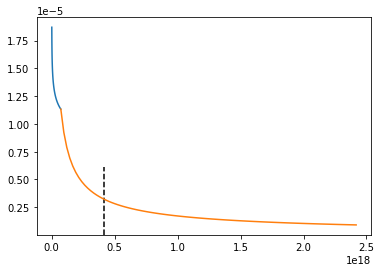

In [28]:
simulate_spectrum(10)

In [ ]:
print(AsymmetricUncertainty(5,0.5,0.3) >  AsymmetricUncertainty(4,0.8,0.5))
print(AsymmetricUncertainty(5,0.5,0.3) >> AsymmetricUncertainty(4,0.8,0.5))

In [ ]:
display(results.loc[425,])
E_range = np.logspace(np.log10(0.3),np.log10(10),100)

E_o = results.loc[425,"nu_o"]*6.62607015e-34/1.6021773E-16
E_x = results.loc[425,"nu_x"]*6.62607015e-34/1.6021773E-16
F_o = results.loc[425,"F_o"]
F_x = results.loc[425,"F_x"]
spectrum = E_range**-beta.value
scale = F_x.value/spectrum[len(spectrum)//2]
spectrum = scale * spectrum
spec1 = E_range**-beta.maximum
scale1 = F_x.value/spec1[len(spec1)//2]
spec1 = scale1 * spec1
spec2 = E_range**-beta.minimum
scale2 = F_x.value/spec2[len(spec2)//2]
spec2 = scale2 * spec2

plt.style.use("seaborn-poster")
fig,ax = plt.subplots(figsize=(9,6),facecolor="none")

plt.fill_between([0.003262755,0.0016531293],[1,1],alpha=0.5,fc="darkorange",label="Optical band")
plt.fill_between([0.3,10],[1,1],alpha=0.5,fc="turquoise",label="X-ray band")
plt.errorbar([E_o,E_x],[F_o.value,F_x.value],xerr=[(0,E_x-0.3),(0,10-E_x)],
             yerr=[(0.000013,F_x.value-1e-6),(0,F_o.value-F_x.value)],
             uplims=[1,0],capsize=0,elinewidth=2,marker=".",linestyle=":",color="k",label="Observed flux")
plt.fill_between(E_range,spectrum,fc="none",ec="k",hatch="/")
plt.fill_between(E_range,spec1,spec2,color="slateblue",label=r"$\beta_x=0.77_{-0.29}^{+0.32}$")
plt.text(1.1e-2,1.1e-5,r"$F\propto\nu^{(-\beta_{ox}\approx\mathrm{-0.2})}$",size=18,rotation=-13)

plt.legend(loc="upper left",bbox_to_anchor=(1,1))
plt.grid(linestyle="--")
plt.xlim(1e-3,30)
plt.ylim(5e-7,2e-4)
plt.yscale("log")
plt.xscale("log")
plt.gca().set_xticks([0.001,0.01,0.3,10])
plt.gca().set_xticklabels(["$10^{-3}$","$10^{-2}$",0.3,10])
plt.title(r"Example: GRB 160624A, $t\approx160$ s")
plt.xlabel("Energy [keV]")
plt.ylabel("Flux density [Jy]")
fig.savefig("./Required Files/Generated Files (Python)/160624A.png",bbox_inches="tight",dpi=300)